In [1]:
# Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import random_split, DataLoader, Subset
from torchvision.models import resnet18, mobilenet_v2, squeezenet1_1
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import os
from collections import Counter

### Data and visualisation

In [2]:
# Load and Describe Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Extract labels from the dataset
train_labels = [train_dataset.classes[label] for _, label in train_dataset]
test_labels = [test_dataset.classes[label] for _, label in test_dataset]

# Get unique class labels and sort them for consistency
unique_classes = sorted(set(train_labels + test_labels))
num_classes = len(unique_classes)

# Count the occurrences of each class in the training and test sets
train_counts = Counter(train_labels)
test_counts = Counter(test_labels)

# Ensure each class has a count (fill missing classes with 0)
train_class_counts = [train_counts.get(cls, 0) for cls in unique_classes]
test_class_counts = [test_counts.get(cls, 0) for cls in unique_classes]

# Print dataset sizes
print(f"Training dataset size: {len(train_dataset)} samples")
print(f"Test dataset size: {len(test_dataset)} samples")



Files already downloaded and verified
Files already downloaded and verified
Training dataset size: 50000 samples
Test dataset size: 10000 samples


In [3]:
# Split the training dataset into 80% training and 20% validation
train_indices, val_indices = train_test_split(
    range(len(train_dataset)),
    test_size=0.2,
    stratify=[label for _, label in train_dataset],
    random_state=42
)

train_subset = Subset(train_dataset, train_indices)
val_subset = Subset(train_dataset, val_indices)

# DataLoaders
train_loader = DataLoader(train_subset, batch_size=256, shuffle=True, num_workers=2)
val_loader = DataLoader(val_subset, batch_size=256, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=2)

# Extract labels from the dataset
train_labels = [train_dataset.classes[label] for _, label in train_subset]
val_labels = [train_dataset.classes[label] for _, label in val_subset]

# Get unique class labels and sort them for consistency
unique_classes = sorted(set(train_labels + val_labels + test_labels))
num_classes = len(unique_classes)

# Count the occurrences of each class in the training, validation, and test sets
train_counts = Counter(train_labels)
val_counts = Counter(val_labels)

# Ensure each class has a count (fill missing classes with 0)
train_class_counts = [train_counts.get(cls, 0) for cls in unique_classes]
val_class_counts = [val_counts.get(cls, 0) for cls in unique_classes]


Training dataset size: 40000 samples
Validation dataset size: 10000 samples
Test dataset size: 10000 samples


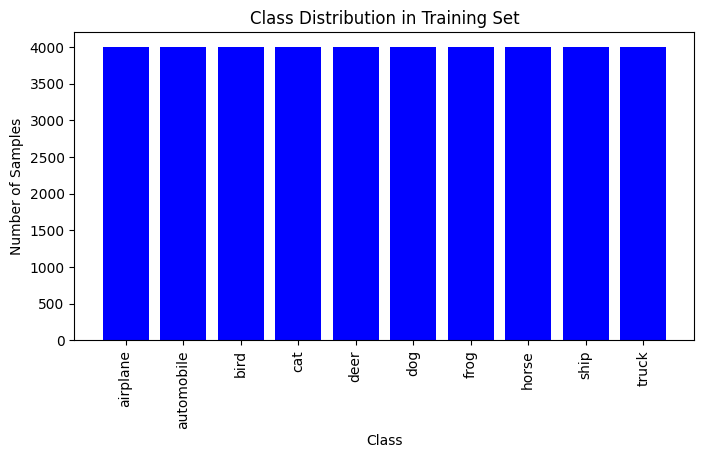

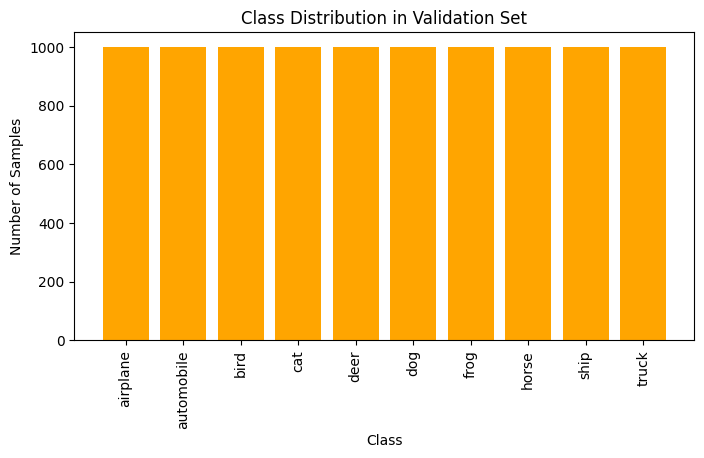

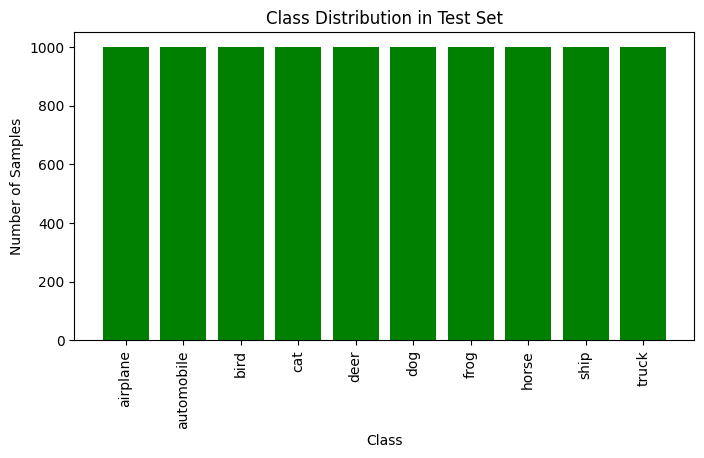

In [4]:
# Print dataset sizes
print(f"Training dataset size: {len(train_subset)} samples")
print(f"Validation dataset size: {len(val_subset)} samples")
print(f"Test dataset size: {len(test_dataset)} samples")

# Plot the distribution for the training set
plt.figure(figsize=(8, 4))
plt.bar(unique_classes, train_class_counts, color='blue')
plt.title("Class Distribution in Training Set")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.xticks(rotation=90)
plt.show()

# Plot the distribution for the validation set
plt.figure(figsize=(8, 4))
plt.bar(unique_classes, val_class_counts, color='orange')
plt.title("Class Distribution in Validation Set")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.xticks(rotation=90)
plt.show()

# Plot the distribution for the test set
plt.figure(figsize=(8, 4))
plt.bar(unique_classes, test_class_counts, color='green')
plt.title("Class Distribution in Test Set")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.xticks(rotation=90)
plt.show()

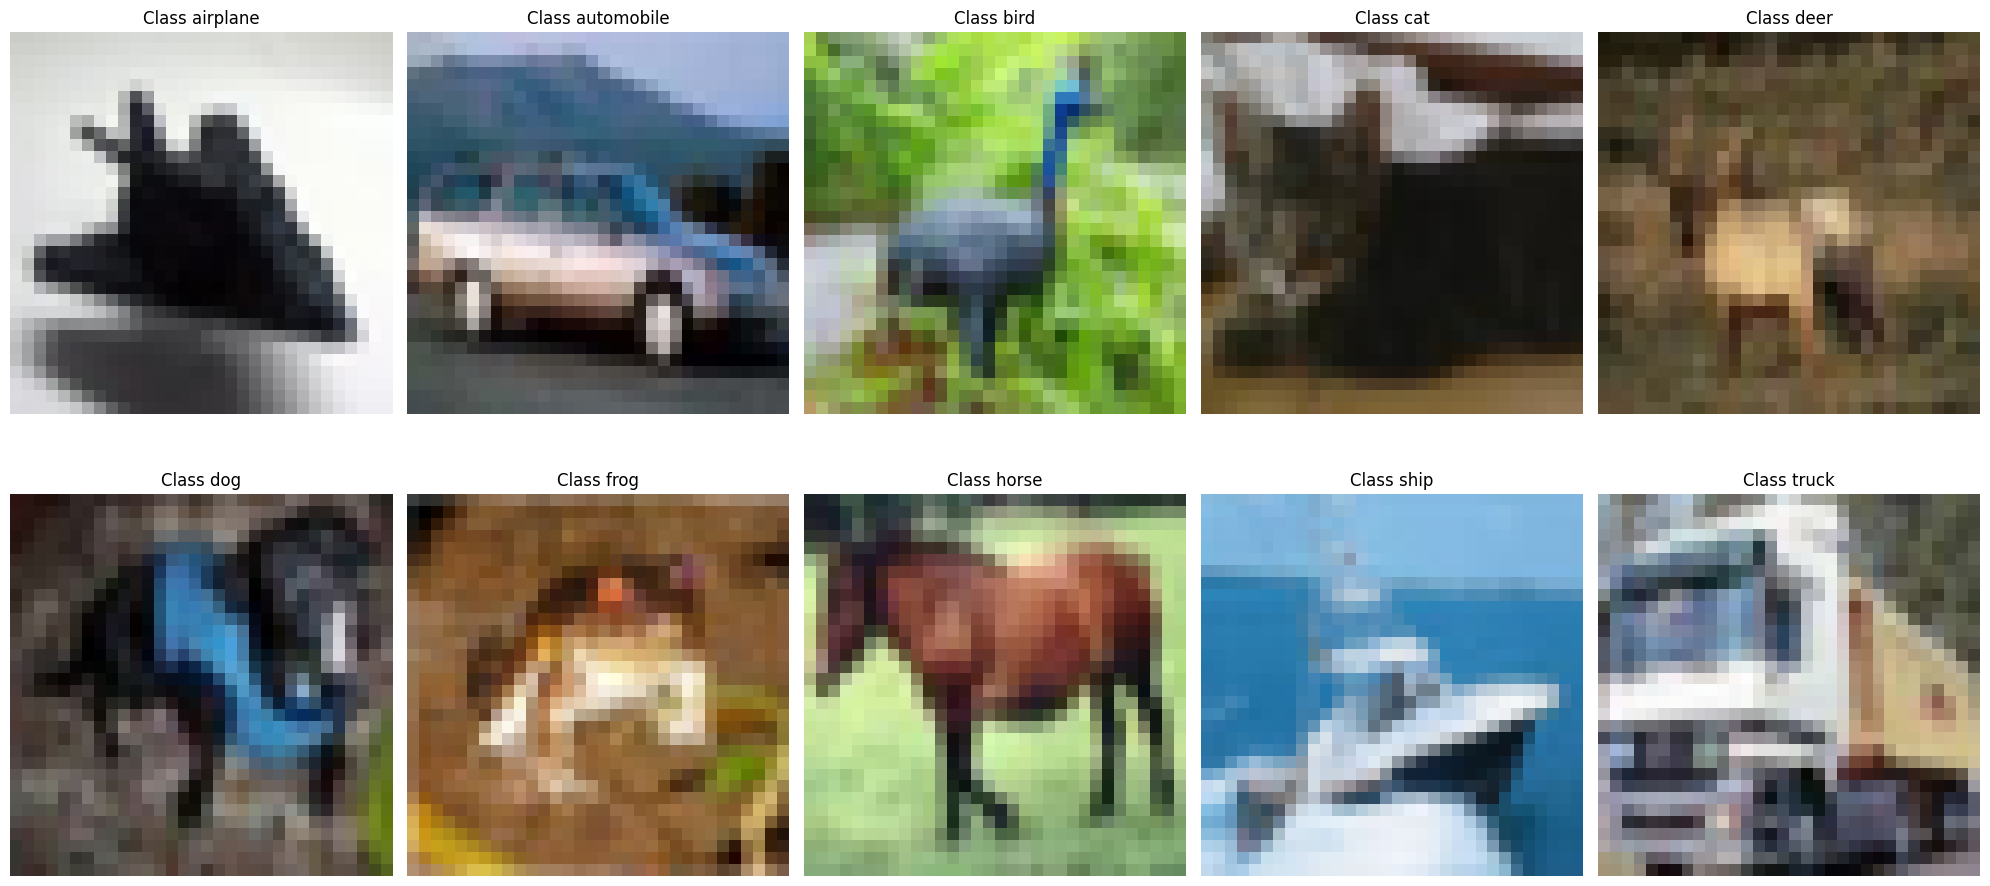

In [5]:
# Visualize sample images for each class
class_samples = {}

# Iterate through the training dataset and select one sample for each class
for img, label in train_dataset:
    class_name = train_dataset.classes[label]
    if class_name not in class_samples:
        class_samples[class_name] = img

    # Break the loop if we already have one sample for each class
    if len(class_samples) == num_classes:
        break

# Plot the sample images for each class
plt.figure(figsize=(20, 10))
for i, cls in enumerate(unique_classes):
    if cls in class_samples:
        img = class_samples[cls]
        img = img / 2 + 0.5  # Unnormalize the image
        np_img = img.numpy()
        np_img = np.transpose(np_img, (1, 2, 0))  # Rearrange dimensions for plotting

        plt.subplot(2, 5, i + 1)  # Create subplots (2 rows, 5 columns)
        plt.imshow(np_img)
        plt.title(f"Class {cls}")
        plt.axis('off')

plt.tight_layout()
plt.show()



### MobileNet V2 Model Architecture

In [40]:
#Define MobileNetV2 architecture

class ConvBNReLU(nn.Sequential):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, groups=1):
        padding = (kernel_size - 1) // 2
        super(ConvBNReLU, self).__init__(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, groups=groups, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU6(inplace=True)
        )

class InvertedResidual(nn.Module):
    def __init__(self, in_channels, out_channels, stride, expand_ratio):
        super(InvertedResidual, self).__init__()
        self.stride = stride
        hidden_dim = in_channels * expand_ratio
        self.use_res_connect = self.stride == 1 and in_channels == out_channels

        layers = []
        if expand_ratio != 1:
            # 1x1 expansion
            layers.append(ConvBNReLU(in_channels, hidden_dim, kernel_size=1))
        # 3x3 depthwise convolution
        layers.extend([
            ConvBNReLU(hidden_dim, hidden_dim, stride=stride, groups=hidden_dim),
            # 1x1 projection
            nn.Conv2d(hidden_dim, out_channels, 1, 1, 0, bias=False),
            nn.BatchNorm2d(out_channels),
        ])
        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)

class MobileNetV2(nn.Module):
    def __init__(self, num_classes=10, width_mult=1.0):
        super(MobileNetV2, self).__init__()
        # Setting of inverted residual blocks
        inverted_residual_setting = [
            # t, c, n, s
            [1, 16, 1, 1],
            [6, 24, 2, 2],
            [6, 32, 3, 2],
            [6, 64, 4, 2],
            [6, 96, 3, 1],
            [6, 160, 3, 2],
            [6, 320, 1, 1],
        ]

        input_channel = 32
        last_channel = 1280

        # First layer: Conv2d with stride 2
        self.features = [ConvBNReLU(3, input_channel, stride=2)]
        
        # Building inverted residual blocks
        for t, c, n, s in inverted_residual_setting:
            output_channel = int(c * width_mult)
            for i in range(n):
                stride = s if i == 0 else 1
                self.features.append(InvertedResidual(input_channel, output_channel, stride, expand_ratio=t))
                input_channel = output_channel
        
        # Last layers
        self.features.append(ConvBNReLU(input_channel, last_channel, kernel_size=1))
        
        # Combine feature layers
        self.features = nn.Sequential(*self.features)
        
        # Classifier layer
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(last_channel, num_classes),
        )

        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = x.mean([2, 3])  # Global average pooling
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.zeros_(m.bias)




### Defining some trainings function

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Define training model function
def train_model(model, train_dataset, val_dataset, optimizer=optim.Adam, lr=0.001, epoch_num=100, patience=10, model_name="model_name", 
                regularization_type=None, regularization_strength=None):

    optimizer = optimizer(model.parameters(), lr=lr)
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    best_val_loss = float("inf")
    patience_counter = 0
    epochs = epoch_num
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss, correct_train, total_train = 0, 0, 0
        for inputs, labels in tqdm(train_dataset, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Apply regularization if specified
            if regularization_type == "l1":
                l1_reg = sum(param.abs().sum() for param in model.parameters())
                loss += regularization_strength * l1_reg
            elif regularization_type == "l2":
                l2_reg = sum(param.pow(2).sum() for param in model.parameters())
                loss += regularization_strength * l2_reg
            elif regularization_type == "l1_l2":
                l1_reg = sum(param.abs().sum() for param in model.parameters())
                l2_reg = sum(param.pow(2).sum() for param in model.parameters())
                loss += regularization_strength * (l1_reg + l2_reg)

            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            # Calculate training accuracy
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_loss /= len(train_dataset)
        train_accuracy = correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()
        val_loss, correct_val, total_val = 0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_dataset:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Apply regularization if specified
                if regularization_type == "l1":
                    l1_reg = sum(param.abs().sum() for param in model.parameters())
                    loss += regularization_strength * l1_reg
                elif regularization_type == "l2":
                    l2_reg = sum(param.pow(2).sum() for param in model.parameters())
                    loss += regularization_strength * l2_reg
                elif regularization_type == "l1_l2":
                    l1_reg = sum(param.abs().sum() for param in model.parameters())
                    l2_reg = sum(param.pow(2).sum() for param in model.parameters())
                    loss += regularization_strength * (l1_reg + l2_reg)

                val_loss += loss.item()

                # Calculate validation accuracy
                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

        val_loss /= len(val_dataset)
        val_accuracy = correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Print results per epoch
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
              f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping...")
                break

    # Save the final model at the end of training
    save_path = f"models/{model_name}.pth"  # Define the save path with the custom name
    torch.save(model.state_dict(), save_path)
    print(f"Training complete. Final model saved at '{save_path}'")

    return model, train_losses, val_losses, train_accuracies, val_accuracies


In [10]:
def plot_loss_accuracy_curves(train_losses, val_losses, train_accuracies, val_accuracies, model_name="model_name"):
    plt.figure(figsize=(14, 5))

    # Plot Loss Curves
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f"{model_name} - Loss Curves ")
    plt.legend()

    # Plot Accuracy Curves
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f"{model_name} - Accuracy Curves")
    plt.legend()

    # Display the plots
    plt.show()



In [11]:
# Confusion Matrix Evaluation Function
def evaluate_model(model, data_loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_preds), np.array(all_labels)

# Plot Confusion Matrix with Adjustable Size
def plot_confusion_matrix(y_true, y_pred, classes, figsize=(10, 10), model_name="model_name"):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

    # Adjust figure size
    fig, ax = plt.subplots(figsize=figsize)
    disp.plot(ax=ax, cmap=plt.cm.Blues)
    plt.xticks(rotation=45)
    plt.title(f"{model_name} - Confusion Matrix ")
    plt.show()



### MobileNet V2 Base Model

In [12]:
# Hyperparameter tuning
model = MobileNetV2(num_classes=10)
train_dataset = train_loader
val_dataset = val_loader
optimizer=optim.Adam
learning_rate=0.001
epochs =100
patience=10
regularization=None
regularization_strength=None
models = {}
model_name = "MobileNetV2_base"

#Training model
model_train, train_loss, val_loss, train_acc, val_acc = train_model(model, train_dataset, val_dataset, optimizer=optimizer, 
                                                                        lr=learning_rate, epoch_num=epochs, patience=patience, model_name=model_name,
                                                                        regularization_type=regularization, regularization_strength=regularization_strength)
#save to each model name
models[f"mdl_{model_name}"] = model_train
models[f"train_loss_{model_name}"] = train_loss
models[f"val_loss_{model_name}"] = val_loss
models[f"train_acc_{model_name}"] = train_acc
models[f"val_acc_{model_name}"] = val_acc

Epoch 1/100, Train Loss: 2.0737, Train Accuracy: 0.2227, Validation Loss: 1.8462, Validation Accuracy: 0.3049


Epoch 2/100, Train Loss: 1.6925, Train Accuracy: 0.3685, Validation Loss: 1.6129, Validation Accuracy: 0.4089


Epoch 3/100, Train Loss: 1.5034, Train Accuracy: 0.4466, Validation Loss: 1.6165, Validation Accuracy: 0.4227


Epoch 4/100, Train Loss: 1.3756, Train Accuracy: 0.4960, Validation Loss: 1.4168, Validation Accuracy: 0.4893


Epoch 5/100, Train Loss: 1.2692, Train Accuracy: 0.5373, Validation Loss: 1.3483, Validation Accuracy: 0.5080


Epoch 6/100, Train Loss: 1.1841, Train Accuracy: 0.5700, Validation Loss: 1.3097, Validation Accuracy: 0.5351


Epoch 7/100, Train Loss: 1.1013, Train Accuracy: 0.6033, Validation Loss: 1.2990, Validation Accuracy: 0.5433


Epoch 8/100, Train Loss: 1.0395, Train Accuracy: 0.6263, Validation Loss: 1.2439, Validation Accuracy: 0.5590


Epoch 9/100, Train Loss: 0.9749, Train Accuracy: 0.6526, Validation Loss: 1.2067, Validation Accuracy: 0.5796


Epoch 10/100, Train Loss: 0.9136, Train Accuracy: 0.6763, Validation Loss: 1.2163, Validation Accuracy: 0.5786


Epoch 11/100, Train Loss: 0.8668, Train Accuracy: 0.6935, Validation Loss: 1.1971, Validation Accuracy: 0.5935


Epoch 12/100, Train Loss: 0.8202, Train Accuracy: 0.7083, Validation Loss: 1.2276, Validation Accuracy: 0.5824


Epoch 13/100, Train Loss: 0.7719, Train Accuracy: 0.7251, Validation Loss: 1.2116, Validation Accuracy: 0.6000


Epoch 14/100, Train Loss: 0.7187, Train Accuracy: 0.7438, Validation Loss: 1.3124, Validation Accuracy: 0.5821


Epoch 15/100, Train Loss: 0.6899, Train Accuracy: 0.7570, Validation Loss: 1.2565, Validation Accuracy: 0.5979


Epoch 16/100, Train Loss: 0.6440, Train Accuracy: 0.7732, Validation Loss: 1.2434, Validation Accuracy: 0.6036


Epoch 17/100, Train Loss: 0.6055, Train Accuracy: 0.7877, Validation Loss: 1.3025, Validation Accuracy: 0.6013


Epoch 18/100, Train Loss: 0.5668, Train Accuracy: 0.7994, Validation Loss: 1.2778, Validation Accuracy: 0.6045


Epoch 19/100, Train Loss: 0.5352, Train Accuracy: 0.8098, Validation Loss: 1.3015, Validation Accuracy: 0.6077


Epoch 20/100, Train Loss: 0.5115, Train Accuracy: 0.8198, Validation Loss: 1.3696, Validation Accuracy: 0.6063


Epoch 21/100, Train Loss: 0.4809, Train Accuracy: 0.8313, Validation Loss: 1.3501, Validation Accuracy: 0.6131
Early stopping...
Training complete. Final model saved at 'models/MobileNetV2_base.pth'


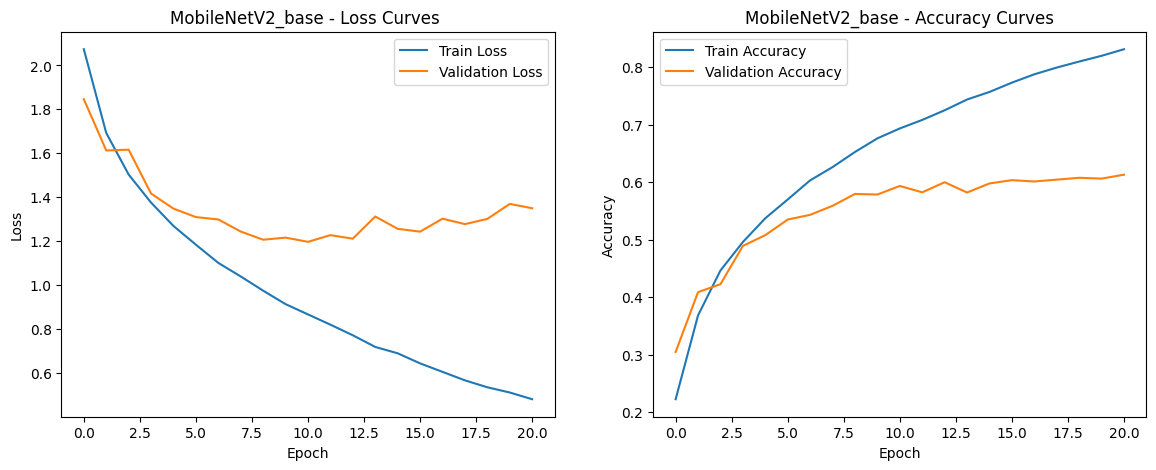

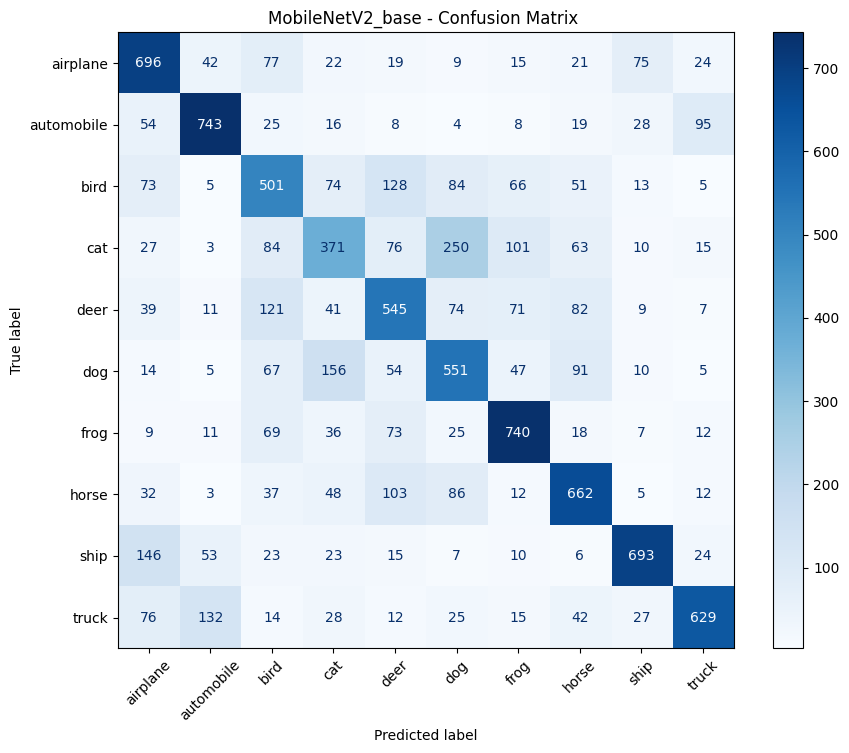

In [13]:
# Loss and accuracy curves 
model_name = "MobileNetV2_base"

model = models[f"mdl_{model_name}"] 
train_losses = models[f"train_loss_{model_name}"]
val_losses = models[f"val_loss_{model_name}"]
train_accuracies = models[f"train_acc_{model_name}"]
val_accuracies = models[f"val_acc_{model_name}"]

plot_loss_accuracy_curves(train_losses, val_losses, train_accuracies, val_accuracies, model_name=model_name)

# Plot confusion matrix
val_preds, val_labels = evaluate_model(model, val_dataset)
plot_confusion_matrix(val_labels, val_preds, classes=unique_classes, figsize=(10, 8), model_name=model_name) 

## OPTIMISATION

### MobileNetV2 model optimisation-1

In [15]:
# Hyperparameter tuning
model = MobileNetV2(num_classes=10)
train_dataset = train_loader
val_dataset = val_loader
optimizer=optim.Adam
learning_rate=0.0001
epochs =100
patience=10
regularization="L1"
regularization_strength=0.001
models = {}
model_name = "MobileNetV2_opt1"

#Training model
model_train, train_loss, val_loss, train_acc, val_acc = train_model(model, train_dataset, val_dataset, optimizer=optimizer, 
                                                                        lr=learning_rate, epoch_num=epochs, patience=patience, model_name=model_name,
                                                                        regularization_type=regularization, regularization_strength=regularization_strength)

#save to each model name
models[f"mdl_{model_name}"] = model_train
models[f"train_loss_{model_name}"] = train_loss
models[f"val_loss_{model_name}"] = val_loss
models[f"train_acc_{model_name}"] = train_acc
models[f"val_acc_{model_name}"] = val_acc

Epoch 1/100, Train Loss: 2.2461, Train Accuracy: 0.1526, Validation Loss: 2.1703, Validation Accuracy: 0.1827


Epoch 2/100, Train Loss: 2.0948, Train Accuracy: 0.2133, Validation Loss: 2.0490, Validation Accuracy: 0.2270


Epoch 3/100, Train Loss: 1.9857, Train Accuracy: 0.2515, Validation Loss: 1.9827, Validation Accuracy: 0.2514


Epoch 4/100, Train Loss: 1.9010, Train Accuracy: 0.2869, Validation Loss: 1.9362, Validation Accuracy: 0.2671


Epoch 5/100, Train Loss: 1.8255, Train Accuracy: 0.3146, Validation Loss: 1.8943, Validation Accuracy: 0.2897


Epoch 6/100, Train Loss: 1.7624, Train Accuracy: 0.3446, Validation Loss: 1.8735, Validation Accuracy: 0.2958


Epoch 7/100, Train Loss: 1.7012, Train Accuracy: 0.3675, Validation Loss: 1.8596, Validation Accuracy: 0.3036


Epoch 8/100, Train Loss: 1.6465, Train Accuracy: 0.3910, Validation Loss: 1.8509, Validation Accuracy: 0.3170


Epoch 9/100, Train Loss: 1.5949, Train Accuracy: 0.4097, Validation Loss: 1.8578, Validation Accuracy: 0.3183


Epoch 10/100, Train Loss: 1.5393, Train Accuracy: 0.4329, Validation Loss: 1.8754, Validation Accuracy: 0.3147


Epoch 11/100, Train Loss: 1.4898, Train Accuracy: 0.4528, Validation Loss: 1.8914, Validation Accuracy: 0.3191


Epoch 12/100, Train Loss: 1.4430, Train Accuracy: 0.4675, Validation Loss: 1.9009, Validation Accuracy: 0.3191


Epoch 13/100, Train Loss: 1.3985, Train Accuracy: 0.4870, Validation Loss: 1.9472, Validation Accuracy: 0.3156


Epoch 14/100, Train Loss: 1.3446, Train Accuracy: 0.5090, Validation Loss: 1.9863, Validation Accuracy: 0.3125


Epoch 15/100, Train Loss: 1.3057, Train Accuracy: 0.5233, Validation Loss: 2.0070, Validation Accuracy: 0.3168


Epoch 16/100, Train Loss: 1.2565, Train Accuracy: 0.5432, Validation Loss: 2.0281, Validation Accuracy: 0.3180


Epoch 17/100, Train Loss: 1.2086, Train Accuracy: 0.5615, Validation Loss: 2.0896, Validation Accuracy: 0.3133


Epoch 18/100, Train Loss: 1.1624, Train Accuracy: 0.5799, Validation Loss: 2.1243, Validation Accuracy: 0.3064
Early stopping...
Training complete. Final model saved at 'models/MobileNetV2_opt1.pth'


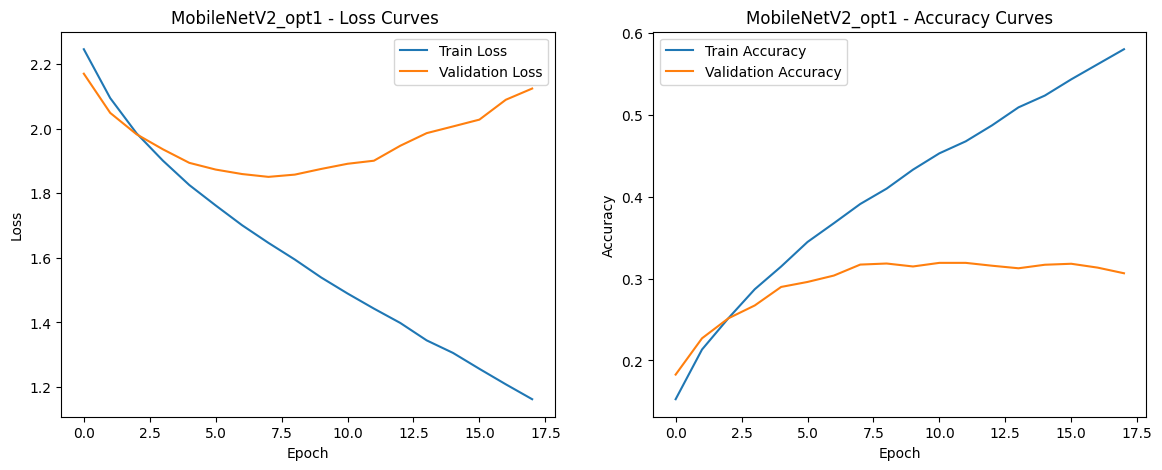

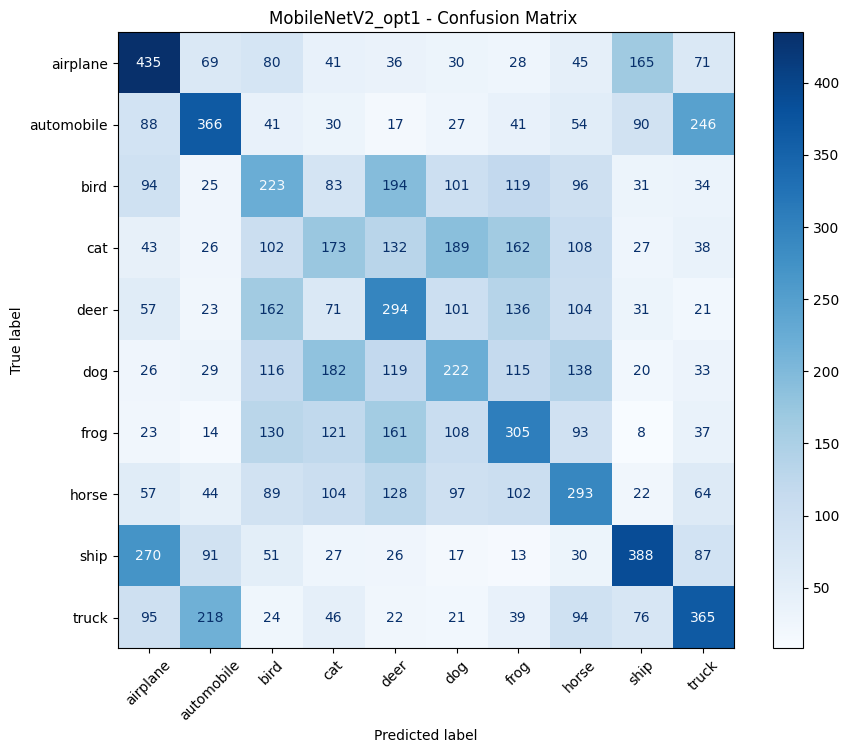

In [16]:
# Loss and accuracy curves 
model_name = "MobileNetV2_opt1"

model = models[f"mdl_{model_name}"] 
train_losses = models[f"train_loss_{model_name}"]
val_losses = models[f"val_loss_{model_name}"]
train_accuracies = models[f"train_acc_{model_name}"]
val_accuracies = models[f"val_acc_{model_name}"]

plot_loss_accuracy_curves(train_losses, val_losses, train_accuracies, val_accuracies, model_name=model_name)

# Plot confusion matrix
val_preds, val_labels = evaluate_model(model, val_dataset)
plot_confusion_matrix(val_labels, val_preds, classes=unique_classes, figsize=(10, 8), model_name=model_name) 


### MobileNetV2 model optimisation-2

In [17]:
# Hyperparameter tuning
model = MobileNetV2(num_classes=10)
train_dataset = train_loader
val_dataset = val_loader
optimizer=optim.Adam
learning_rate=0.0001
epochs =100
patience=10
regularization="L2"
regularization_strength=0.0001
models = {}
model_name = "MobileNetV2_opt2"

#Training model
model_train, train_loss, val_loss, train_acc, val_acc = train_model(model, train_dataset, val_dataset, optimizer=optimizer, 
                                                                        lr=learning_rate, epoch_num=epochs, patience=patience, model_name=model_name,
                                                                        regularization_type=regularization, regularization_strength=regularization_strength)

#save to each model name
models[f"mdl_{model_name}"] = model_train
models[f"train_loss_{model_name}"] = train_loss
models[f"val_loss_{model_name}"] = val_loss
models[f"train_acc_{model_name}"] = train_acc
models[f"val_acc_{model_name}"] = val_acc

Epoch 1/100, Train Loss: 2.2161, Train Accuracy: 0.1562, Validation Loss: 2.1275, Validation Accuracy: 0.1896


Epoch 2/100, Train Loss: 2.0481, Train Accuracy: 0.2218, Validation Loss: 2.0264, Validation Accuracy: 0.2324


Epoch 3/100, Train Loss: 1.9587, Train Accuracy: 0.2585, Validation Loss: 1.9785, Validation Accuracy: 0.2485


Epoch 4/100, Train Loss: 1.8991, Train Accuracy: 0.2847, Validation Loss: 1.9403, Validation Accuracy: 0.2613


Epoch 5/100, Train Loss: 1.8313, Train Accuracy: 0.3129, Validation Loss: 1.9078, Validation Accuracy: 0.2815


Epoch 6/100, Train Loss: 1.7740, Train Accuracy: 0.3376, Validation Loss: 1.8843, Validation Accuracy: 0.2845


Epoch 7/100, Train Loss: 1.7120, Train Accuracy: 0.3619, Validation Loss: 1.8780, Validation Accuracy: 0.3022


Epoch 8/100, Train Loss: 1.6574, Train Accuracy: 0.3895, Validation Loss: 1.8645, Validation Accuracy: 0.3059


Epoch 9/100, Train Loss: 1.6050, Train Accuracy: 0.4055, Validation Loss: 1.8764, Validation Accuracy: 0.3052


Epoch 10/100, Train Loss: 1.5521, Train Accuracy: 0.4303, Validation Loss: 1.8804, Validation Accuracy: 0.3085


Epoch 11/100, Train Loss: 1.5081, Train Accuracy: 0.4482, Validation Loss: 1.8895, Validation Accuracy: 0.3159


Epoch 12/100, Train Loss: 1.4479, Train Accuracy: 0.4712, Validation Loss: 1.9092, Validation Accuracy: 0.3162


Epoch 13/100, Train Loss: 1.3993, Train Accuracy: 0.4869, Validation Loss: 1.9388, Validation Accuracy: 0.3188


Epoch 14/100, Train Loss: 1.3585, Train Accuracy: 0.5018, Validation Loss: 1.9710, Validation Accuracy: 0.3139


Epoch 15/100, Train Loss: 1.2990, Train Accuracy: 0.5290, Validation Loss: 2.0219, Validation Accuracy: 0.3156


Epoch 16/100, Train Loss: 1.2529, Train Accuracy: 0.5453, Validation Loss: 2.0477, Validation Accuracy: 0.3116


Epoch 17/100, Train Loss: 1.2138, Train Accuracy: 0.5623, Validation Loss: 2.0976, Validation Accuracy: 0.3042


Epoch 18/100, Train Loss: 1.1539, Train Accuracy: 0.5839, Validation Loss: 2.1170, Validation Accuracy: 0.3129
Early stopping...
Training complete. Final model saved at 'models/MobileNetV2_opt2.pth'


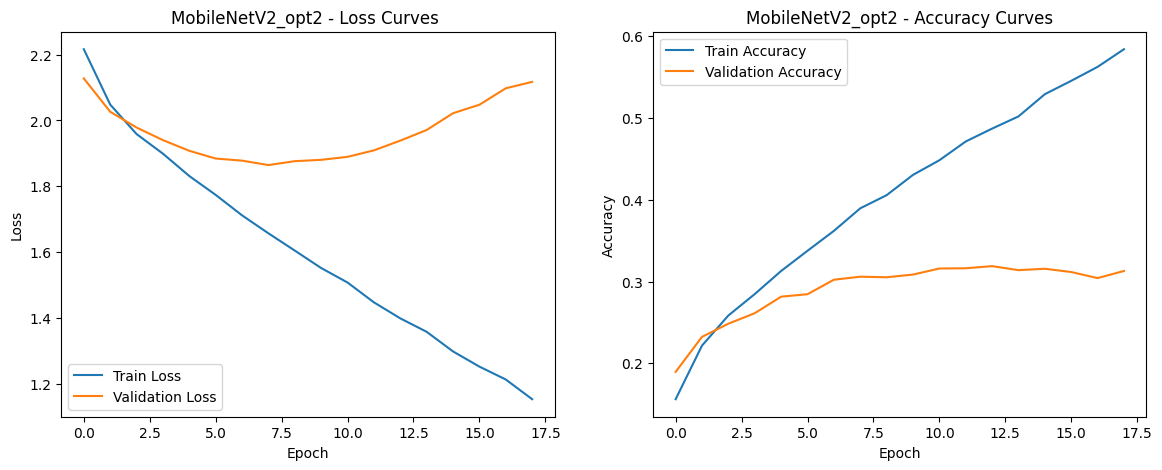

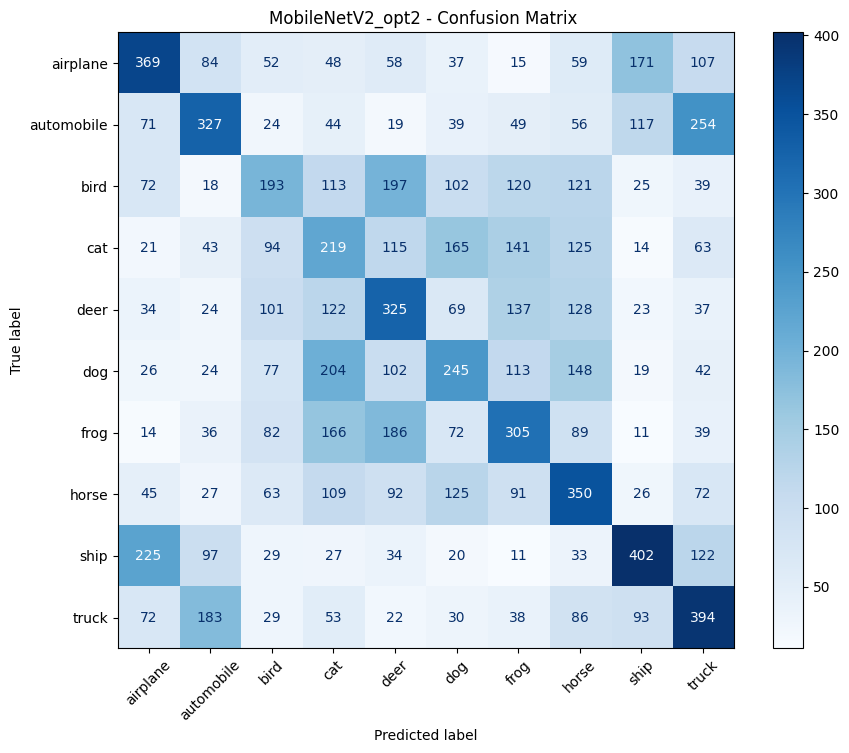

In [18]:
# Loss and accuracy curves 
model_name = "MobileNetV2_opt2"

model = models[f"mdl_{model_name}"] 
train_losses = models[f"train_loss_{model_name}"]
val_losses = models[f"val_loss_{model_name}"]
train_accuracies = models[f"train_acc_{model_name}"]
val_accuracies = models[f"val_acc_{model_name}"]

plot_loss_accuracy_curves(train_losses, val_losses, train_accuracies, val_accuracies, model_name=model_name)

# Plot confusion matrix
val_preds, val_labels = evaluate_model(model, val_dataset)
plot_confusion_matrix(val_labels, val_preds, classes=unique_classes, figsize=(10, 8), model_name=model_name) 

### MobileNetV2 model optimisation-3

In [19]:
# Hyperparameter tuning
model = MobileNetV2(num_classes=10)
train_dataset = train_loader
val_dataset = val_loader
optimizer=optim.Adam
learning_rate=0.0001
epochs =100
patience=10
regularization="L1L2"
regularization_strength=0.01
models = {}
model_name = "MobileNetV2_opt3"

#Training model
model_train, train_loss, val_loss, train_acc, val_acc = train_model(model, train_dataset, val_dataset, optimizer=optimizer, 
                                                                        lr=learning_rate, epoch_num=epochs, patience=patience, model_name=model_name,
                                                                        regularization_type=regularization, regularization_strength=regularization_strength)

#save to each model name
models[f"mdl_{model_name}"] = model_train
models[f"train_loss_{model_name}"] = train_loss
models[f"val_loss_{model_name}"] = val_loss
models[f"train_acc_{model_name}"] = train_acc
models[f"val_acc_{model_name}"] = val_acc


Epoch 1/100, Train Loss: 2.2444, Train Accuracy: 0.1556, Validation Loss: 2.1733, Validation Accuracy: 0.1889


Epoch 2/100, Train Loss: 2.0979, Train Accuracy: 0.2157, Validation Loss: 2.0672, Validation Accuracy: 0.2199


Epoch 3/100, Train Loss: 1.9849, Train Accuracy: 0.2569, Validation Loss: 1.9920, Validation Accuracy: 0.2544


Epoch 4/100, Train Loss: 1.9022, Train Accuracy: 0.2885, Validation Loss: 1.9423, Validation Accuracy: 0.2703


Epoch 5/100, Train Loss: 1.8266, Train Accuracy: 0.3186, Validation Loss: 1.8997, Validation Accuracy: 0.2902


Epoch 6/100, Train Loss: 1.7608, Train Accuracy: 0.3464, Validation Loss: 1.8839, Validation Accuracy: 0.2976


Epoch 7/100, Train Loss: 1.6966, Train Accuracy: 0.3736, Validation Loss: 1.8752, Validation Accuracy: 0.3076


Epoch 8/100, Train Loss: 1.6427, Train Accuracy: 0.3931, Validation Loss: 1.8681, Validation Accuracy: 0.3189


Epoch 9/100, Train Loss: 1.5886, Train Accuracy: 0.4135, Validation Loss: 1.8751, Validation Accuracy: 0.3121


Epoch 10/100, Train Loss: 1.5331, Train Accuracy: 0.4356, Validation Loss: 1.8752, Validation Accuracy: 0.3231


Epoch 11/100, Train Loss: 1.4851, Train Accuracy: 0.4537, Validation Loss: 1.9121, Validation Accuracy: 0.3271


Epoch 12/100, Train Loss: 1.4367, Train Accuracy: 0.4747, Validation Loss: 1.9310, Validation Accuracy: 0.3239


Epoch 13/100, Train Loss: 1.3789, Train Accuracy: 0.4965, Validation Loss: 1.9385, Validation Accuracy: 0.3282


Epoch 14/100, Train Loss: 1.3277, Train Accuracy: 0.5170, Validation Loss: 1.9694, Validation Accuracy: 0.3242


Epoch 15/100, Train Loss: 1.2754, Train Accuracy: 0.5359, Validation Loss: 1.9980, Validation Accuracy: 0.3243


Epoch 16/100, Train Loss: 1.2411, Train Accuracy: 0.5497, Validation Loss: 2.0447, Validation Accuracy: 0.3232


Epoch 17/100, Train Loss: 1.1779, Train Accuracy: 0.5722, Validation Loss: 2.1193, Validation Accuracy: 0.3182


Epoch 18/100, Train Loss: 1.1415, Train Accuracy: 0.5843, Validation Loss: 2.1087, Validation Accuracy: 0.3223
Early stopping...
Training complete. Final model saved at 'models/MobileNetV2_opt3.pth'


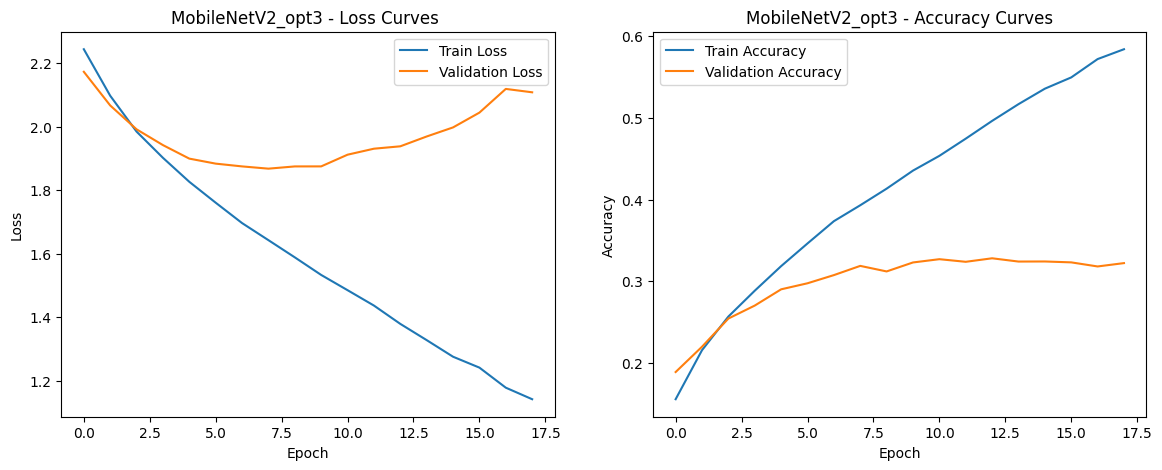

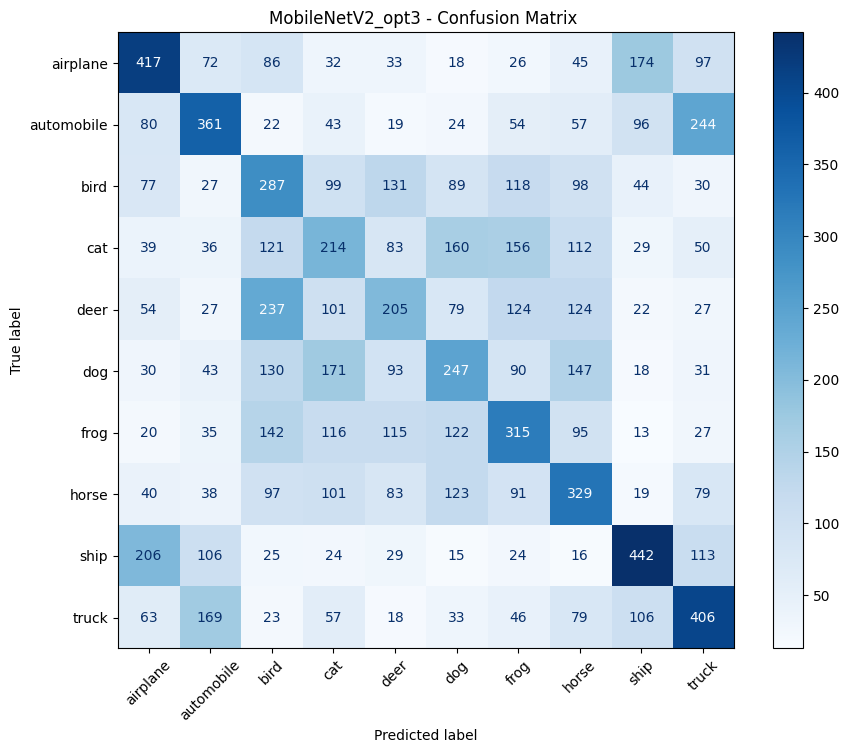

In [20]:
# Loss and accuracy curves 
model_name = "MobileNetV2_opt3"

model = models[f"mdl_{model_name}"] 
train_losses = models[f"train_loss_{model_name}"]
val_losses = models[f"val_loss_{model_name}"]
train_accuracies = models[f"train_acc_{model_name}"]
val_accuracies = models[f"val_acc_{model_name}"]

plot_loss_accuracy_curves(train_losses, val_losses, train_accuracies, val_accuracies, model_name=model_name)

# Plot confusion matrix
val_preds, val_labels = evaluate_model(model, val_dataset)
plot_confusion_matrix(val_labels, val_preds, classes=unique_classes, figsize=(10, 8), model_name=model_name) 

### MobileNetV2 model optimisation-4

In [21]:
# Update batch size
train_loader_128 = DataLoader(train_subset, batch_size=128, shuffle=True, num_workers=4)
val_loader_128 = DataLoader(val_subset, batch_size=128, shuffle=False, num_workers=4)

# Hyperparameter tuning
model = MobileNetV2(num_classes=10)
train_dataset = train_loader_128
val_dataset = val_loader_128
optimizer=optim.Adam
learning_rate=0.0001
epochs =100
patience=10
regularization="L2"
regularization_strength=0.01
models = {}
model_name = "MobileNetV2_opt4"

#Training model
model_train, train_loss, val_loss, train_acc, val_acc = train_model(model, train_dataset, val_dataset, optimizer=optimizer, 
                                                                        lr=learning_rate, epoch_num=epochs, patience=patience, model_name=model_name,
                                                                        regularization_type=regularization, regularization_strength=regularization_strength)

#save to each model name
models[f"mdl_{model_name}"] = model_train
models[f"train_loss_{model_name}"] = train_loss
models[f"val_loss_{model_name}"] = val_loss
models[f"train_acc_{model_name}"] = train_acc
models[f"val_acc_{model_name}"] = val_acc



Epoch 1/100, Train Loss: 2.2188, Train Accuracy: 0.1607, Validation Loss: 2.1061, Validation Accuracy: 0.2127


Epoch 2/100, Train Loss: 2.0227, Train Accuracy: 0.2371, Validation Loss: 1.9762, Validation Accuracy: 0.2495


Epoch 3/100, Train Loss: 1.9120, Train Accuracy: 0.2834, Validation Loss: 1.8956, Validation Accuracy: 0.2860


Epoch 4/100, Train Loss: 1.8243, Train Accuracy: 0.3148, Validation Loss: 1.8370, Validation Accuracy: 0.3146


Epoch 5/100, Train Loss: 1.7467, Train Accuracy: 0.3478, Validation Loss: 1.7813, Validation Accuracy: 0.3389


Epoch 6/100, Train Loss: 1.6788, Train Accuracy: 0.3752, Validation Loss: 1.7469, Validation Accuracy: 0.3541


Epoch 7/100, Train Loss: 1.6178, Train Accuracy: 0.3980, Validation Loss: 1.7328, Validation Accuracy: 0.3632


Epoch 8/100, Train Loss: 1.5598, Train Accuracy: 0.4249, Validation Loss: 1.7093, Validation Accuracy: 0.3706


Epoch 9/100, Train Loss: 1.5141, Train Accuracy: 0.4414, Validation Loss: 1.6980, Validation Accuracy: 0.3857


Epoch 10/100, Train Loss: 1.4590, Train Accuracy: 0.4626, Validation Loss: 1.6978, Validation Accuracy: 0.3857


Epoch 11/100, Train Loss: 1.4131, Train Accuracy: 0.4829, Validation Loss: 1.6850, Validation Accuracy: 0.3979


Epoch 12/100, Train Loss: 1.3660, Train Accuracy: 0.5008, Validation Loss: 1.7023, Validation Accuracy: 0.3907


Epoch 13/100, Train Loss: 1.3214, Train Accuracy: 0.5163, Validation Loss: 1.7158, Validation Accuracy: 0.3909


Epoch 14/100, Train Loss: 1.2733, Train Accuracy: 0.5340, Validation Loss: 1.7423, Validation Accuracy: 0.3919


Epoch 15/100, Train Loss: 1.2332, Train Accuracy: 0.5521, Validation Loss: 1.7434, Validation Accuracy: 0.3982


Epoch 16/100, Train Loss: 1.1836, Train Accuracy: 0.5708, Validation Loss: 1.7850, Validation Accuracy: 0.3979


Epoch 17/100, Train Loss: 1.1445, Train Accuracy: 0.5861, Validation Loss: 1.7913, Validation Accuracy: 0.3906


Epoch 18/100, Train Loss: 1.0992, Train Accuracy: 0.6012, Validation Loss: 1.8411, Validation Accuracy: 0.3903


Epoch 19/100, Train Loss: 1.0606, Train Accuracy: 0.6148, Validation Loss: 1.8441, Validation Accuracy: 0.3886


Epoch 20/100, Train Loss: 1.0278, Train Accuracy: 0.6306, Validation Loss: 1.8882, Validation Accuracy: 0.3876


Epoch 21/100, Train Loss: 0.9851, Train Accuracy: 0.6438, Validation Loss: 1.9340, Validation Accuracy: 0.3853
Early stopping...
Training complete. Final model saved at 'models/MobileNetV2_opt4.pth'


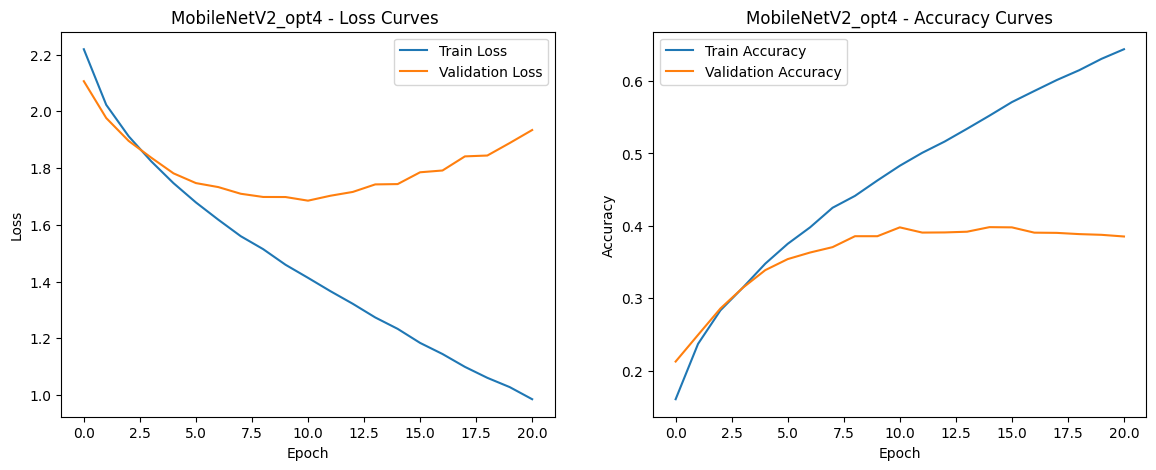

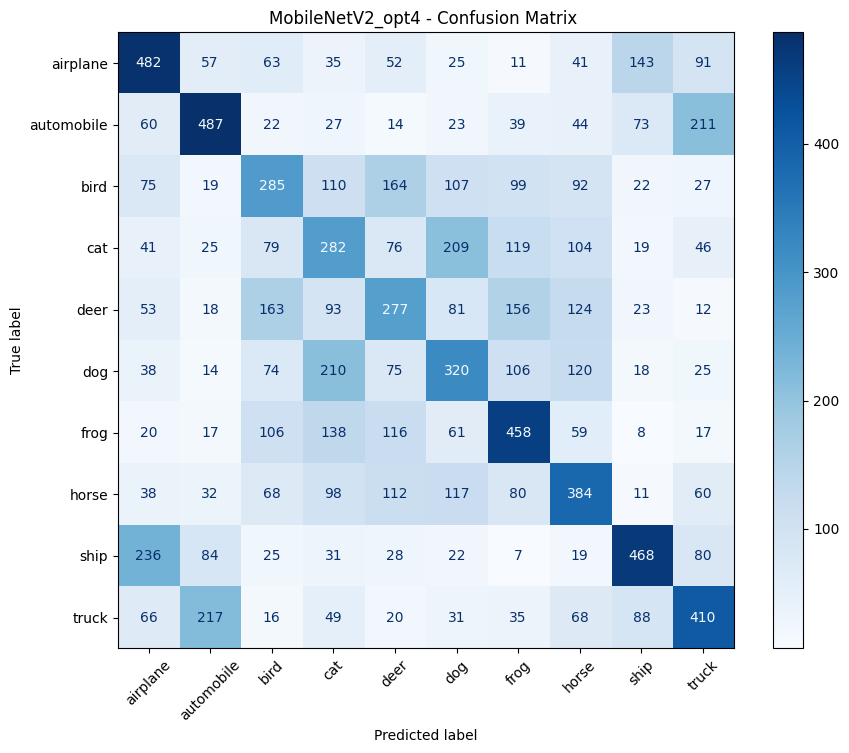

In [22]:
# Loss and accuracy curves 
model_name = "MobileNetV2_opt4"

model = models[f"mdl_{model_name}"] 
train_losses = models[f"train_loss_{model_name}"]
val_losses = models[f"val_loss_{model_name}"]
train_accuracies = models[f"train_acc_{model_name}"]
val_accuracies = models[f"val_acc_{model_name}"]

plot_loss_accuracy_curves(train_losses, val_losses, train_accuracies, val_accuracies, model_name=model_name)

# Plot confusion matrix
val_preds, val_labels = evaluate_model(model, val_dataset)
plot_confusion_matrix(val_labels, val_preds, classes=unique_classes, figsize=(10, 8), model_name=model_name) 

### MobileNetV2 model optimisation-5

In [23]:
# Define the augmentations method
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 datasets with transformations
train_dataset_aug = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform_train)

# Split the training dataset into 80% training and 20% validation
train_indices_aug, val_indices_aug = train_test_split(
    range(len(train_dataset_aug)),
    test_size=0.2,
    stratify=[label for _, label in train_dataset_aug],
    random_state=42
)

train_subset_aug = Subset(train_dataset_aug, train_indices_aug)

In [25]:
# DataLoaders, edit batch size
train_loader_aug = DataLoader(train_subset_aug, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)
val_loader_128 = DataLoader(val_subset, batch_size=128, shuffle=False, num_workers=4)

# Hyperparameter tuning
model = MobileNetV2(num_classes=10)
train_dataset = train_loader_aug
val_dataset = val_loader_128
optimizer=optim.Adam
learning_rate=0.001
epochs =100
patience=10
regularization="L2"
regularization_strength=0.000001
models = {}
model_name = "MobileNetV2_opt5"

#Training model
model_train, train_loss, val_loss, train_acc, val_acc = train_model(model, train_dataset, val_dataset, optimizer=optimizer, 
                                                                        lr=learning_rate, epoch_num=epochs, patience=patience, model_name=model_name,
                                                                        regularization_type=regularization, regularization_strength=regularization_strength)

#save to each model name
models[f"mdl_{model_name}"] = model_train
models[f"train_loss_{model_name}"] = train_loss
models[f"val_loss_{model_name}"] = val_loss
models[f"train_acc_{model_name}"] = train_acc
models[f"val_acc_{model_name}"] = val_acc

Epoch 1/100, Train Loss: 2.1388, Train Accuracy: 0.1948, Validation Loss: 1.9007, Validation Accuracy: 0.2837


Epoch 2/100, Train Loss: 1.9455, Train Accuracy: 0.2645, Validation Loss: 1.7062, Validation Accuracy: 0.3524


Epoch 3/100, Train Loss: 1.8752, Train Accuracy: 0.2964, Validation Loss: 1.6763, Validation Accuracy: 0.3672


Epoch 4/100, Train Loss: 1.8290, Train Accuracy: 0.3247, Validation Loss: 1.6422, Validation Accuracy: 0.3820


Epoch 5/100, Train Loss: 1.7783, Train Accuracy: 0.3392, Validation Loss: 1.6391, Validation Accuracy: 0.3897


Epoch 6/100, Train Loss: 1.7563, Train Accuracy: 0.3515, Validation Loss: 1.5013, Validation Accuracy: 0.4510


Epoch 7/100, Train Loss: 1.7142, Train Accuracy: 0.3748, Validation Loss: 1.4528, Validation Accuracy: 0.4745


Epoch 8/100, Train Loss: 1.6818, Train Accuracy: 0.3866, Validation Loss: 1.4737, Validation Accuracy: 0.4512


Epoch 9/100, Train Loss: 1.6483, Train Accuracy: 0.4007, Validation Loss: 1.4264, Validation Accuracy: 0.4844


Epoch 10/100, Train Loss: 1.6271, Train Accuracy: 0.4086, Validation Loss: 1.3623, Validation Accuracy: 0.5193


Epoch 11/100, Train Loss: 1.6005, Train Accuracy: 0.4239, Validation Loss: 1.3334, Validation Accuracy: 0.5188


Epoch 12/100, Train Loss: 1.5683, Train Accuracy: 0.4352, Validation Loss: 1.3019, Validation Accuracy: 0.5337


Epoch 13/100, Train Loss: 1.5357, Train Accuracy: 0.4513, Validation Loss: 1.2624, Validation Accuracy: 0.5446


Epoch 14/100, Train Loss: 1.5174, Train Accuracy: 0.4587, Validation Loss: 1.2329, Validation Accuracy: 0.5591


Epoch 15/100, Train Loss: 1.5007, Train Accuracy: 0.4608, Validation Loss: 1.2155, Validation Accuracy: 0.5713


Epoch 16/100, Train Loss: 1.4651, Train Accuracy: 0.4789, Validation Loss: 1.2144, Validation Accuracy: 0.5744


Epoch 17/100, Train Loss: 1.4469, Train Accuracy: 0.4862, Validation Loss: 1.1619, Validation Accuracy: 0.5889


Epoch 18/100, Train Loss: 1.4223, Train Accuracy: 0.4956, Validation Loss: 1.1188, Validation Accuracy: 0.6036


Epoch 19/100, Train Loss: 1.4028, Train Accuracy: 0.5017, Validation Loss: 1.1086, Validation Accuracy: 0.6083


Epoch 20/100, Train Loss: 1.3894, Train Accuracy: 0.5046, Validation Loss: 1.0696, Validation Accuracy: 0.6209


Epoch 21/100, Train Loss: 1.3755, Train Accuracy: 0.5137, Validation Loss: 1.0878, Validation Accuracy: 0.6251


Epoch 22/100, Train Loss: 1.3672, Train Accuracy: 0.5164, Validation Loss: 1.0522, Validation Accuracy: 0.6305


Epoch 23/100, Train Loss: 1.3392, Train Accuracy: 0.5242, Validation Loss: 1.0318, Validation Accuracy: 0.6430


Epoch 24/100, Train Loss: 1.3392, Train Accuracy: 0.5220, Validation Loss: 1.0412, Validation Accuracy: 0.6358


Epoch 25/100, Train Loss: 1.3308, Train Accuracy: 0.5299, Validation Loss: 0.9757, Validation Accuracy: 0.6577


Epoch 26/100, Train Loss: 1.3108, Train Accuracy: 0.5367, Validation Loss: 1.0023, Validation Accuracy: 0.6563


Epoch 27/100, Train Loss: 1.2943, Train Accuracy: 0.5401, Validation Loss: 0.9877, Validation Accuracy: 0.6503


Epoch 28/100, Train Loss: 1.2833, Train Accuracy: 0.5466, Validation Loss: 0.9446, Validation Accuracy: 0.6661


Epoch 29/100, Train Loss: 1.2697, Train Accuracy: 0.5531, Validation Loss: 0.9887, Validation Accuracy: 0.6605


Epoch 30/100, Train Loss: 1.2550, Train Accuracy: 0.5594, Validation Loss: 0.9392, Validation Accuracy: 0.6704


Epoch 31/100, Train Loss: 1.2373, Train Accuracy: 0.5634, Validation Loss: 0.9326, Validation Accuracy: 0.6753


Epoch 32/100, Train Loss: 1.2316, Train Accuracy: 0.5650, Validation Loss: 0.8989, Validation Accuracy: 0.6808


Epoch 33/100, Train Loss: 1.2230, Train Accuracy: 0.5700, Validation Loss: 0.9275, Validation Accuracy: 0.6777


Epoch 34/100, Train Loss: 1.2101, Train Accuracy: 0.5741, Validation Loss: 0.8671, Validation Accuracy: 0.6955


Epoch 35/100, Train Loss: 1.1976, Train Accuracy: 0.5800, Validation Loss: 0.9047, Validation Accuracy: 0.6852


Epoch 36/100, Train Loss: 1.1946, Train Accuracy: 0.5798, Validation Loss: 0.8402, Validation Accuracy: 0.7101


Epoch 37/100, Train Loss: 1.1835, Train Accuracy: 0.5823, Validation Loss: 0.8436, Validation Accuracy: 0.7051


Epoch 38/100, Train Loss: 1.1746, Train Accuracy: 0.5878, Validation Loss: 0.8261, Validation Accuracy: 0.7190


Epoch 39/100, Train Loss: 1.1719, Train Accuracy: 0.5918, Validation Loss: 0.8500, Validation Accuracy: 0.7004


Epoch 40/100, Train Loss: 1.1658, Train Accuracy: 0.5932, Validation Loss: 0.8428, Validation Accuracy: 0.7053


Epoch 41/100, Train Loss: 1.1463, Train Accuracy: 0.5991, Validation Loss: 0.8441, Validation Accuracy: 0.7079


Epoch 42/100, Train Loss: 1.1366, Train Accuracy: 0.6044, Validation Loss: 0.8247, Validation Accuracy: 0.7172


Epoch 43/100, Train Loss: 1.1311, Train Accuracy: 0.6041, Validation Loss: 0.8054, Validation Accuracy: 0.7182


Epoch 44/100, Train Loss: 1.1367, Train Accuracy: 0.6028, Validation Loss: 0.8046, Validation Accuracy: 0.7179


Epoch 45/100, Train Loss: 1.1283, Train Accuracy: 0.6024, Validation Loss: 0.7870, Validation Accuracy: 0.7265


Epoch 46/100, Train Loss: 1.1197, Train Accuracy: 0.6083, Validation Loss: 0.8138, Validation Accuracy: 0.7211


Epoch 47/100, Train Loss: 1.1098, Train Accuracy: 0.6126, Validation Loss: 0.7958, Validation Accuracy: 0.7258


Epoch 48/100, Train Loss: 1.1032, Train Accuracy: 0.6151, Validation Loss: 0.8016, Validation Accuracy: 0.7269


Epoch 49/100, Train Loss: 1.0942, Train Accuracy: 0.6200, Validation Loss: 0.7936, Validation Accuracy: 0.7283


Epoch 50/100, Train Loss: 1.0971, Train Accuracy: 0.6156, Validation Loss: 0.7509, Validation Accuracy: 0.7390


Epoch 51/100, Train Loss: 1.0915, Train Accuracy: 0.6202, Validation Loss: 0.7522, Validation Accuracy: 0.7352


Epoch 52/100, Train Loss: 1.0815, Train Accuracy: 0.6240, Validation Loss: 0.7378, Validation Accuracy: 0.7421


Epoch 53/100, Train Loss: 1.0749, Train Accuracy: 0.6243, Validation Loss: 0.7455, Validation Accuracy: 0.7415


Epoch 54/100, Train Loss: 1.0725, Train Accuracy: 0.6257, Validation Loss: 0.7423, Validation Accuracy: 0.7461


Epoch 55/100, Train Loss: 1.0644, Train Accuracy: 0.6282, Validation Loss: 0.7385, Validation Accuracy: 0.7455


Epoch 56/100, Train Loss: 1.0572, Train Accuracy: 0.6330, Validation Loss: 0.7571, Validation Accuracy: 0.7406


Epoch 57/100, Train Loss: 1.0555, Train Accuracy: 0.6286, Validation Loss: 0.6903, Validation Accuracy: 0.7588


Epoch 58/100, Train Loss: 1.0488, Train Accuracy: 0.6343, Validation Loss: 0.7232, Validation Accuracy: 0.7552


Epoch 59/100, Train Loss: 1.0473, Train Accuracy: 0.6346, Validation Loss: 0.7062, Validation Accuracy: 0.7594


Epoch 60/100, Train Loss: 1.0404, Train Accuracy: 0.6382, Validation Loss: 0.7375, Validation Accuracy: 0.7485


Epoch 61/100, Train Loss: 1.0342, Train Accuracy: 0.6418, Validation Loss: 0.7048, Validation Accuracy: 0.7556


Epoch 62/100, Train Loss: 1.0398, Train Accuracy: 0.6362, Validation Loss: 0.7198, Validation Accuracy: 0.7550


Epoch 63/100, Train Loss: 1.0297, Train Accuracy: 0.6397, Validation Loss: 0.7179, Validation Accuracy: 0.7522


Epoch 64/100, Train Loss: 1.0220, Train Accuracy: 0.6463, Validation Loss: 0.6819, Validation Accuracy: 0.7650


Epoch 65/100, Train Loss: 1.0249, Train Accuracy: 0.6447, Validation Loss: 0.6908, Validation Accuracy: 0.7611


Epoch 66/100, Train Loss: 1.0150, Train Accuracy: 0.6497, Validation Loss: 0.6997, Validation Accuracy: 0.7551


Epoch 67/100, Train Loss: 1.0115, Train Accuracy: 0.6476, Validation Loss: 0.6916, Validation Accuracy: 0.7646


Epoch 68/100, Train Loss: 1.0167, Train Accuracy: 0.6439, Validation Loss: 0.6975, Validation Accuracy: 0.7626


Epoch 69/100, Train Loss: 1.0040, Train Accuracy: 0.6484, Validation Loss: 0.7095, Validation Accuracy: 0.7586


Epoch 70/100, Train Loss: 0.9967, Train Accuracy: 0.6527, Validation Loss: 0.6792, Validation Accuracy: 0.7635


Epoch 71/100, Train Loss: 0.9970, Train Accuracy: 0.6547, Validation Loss: 0.6614, Validation Accuracy: 0.7706


Epoch 72/100, Train Loss: 0.9975, Train Accuracy: 0.6530, Validation Loss: 0.7000, Validation Accuracy: 0.7640


Epoch 73/100, Train Loss: 0.9938, Train Accuracy: 0.6520, Validation Loss: 0.6651, Validation Accuracy: 0.7750


Epoch 74/100, Train Loss: 0.9960, Train Accuracy: 0.6509, Validation Loss: 0.6762, Validation Accuracy: 0.7703


Epoch 75/100, Train Loss: 0.9941, Train Accuracy: 0.6541, Validation Loss: 0.6931, Validation Accuracy: 0.7640


Epoch 76/100, Train Loss: 0.9827, Train Accuracy: 0.6584, Validation Loss: 0.6720, Validation Accuracy: 0.7733


Epoch 77/100, Train Loss: 0.9816, Train Accuracy: 0.6594, Validation Loss: 0.6678, Validation Accuracy: 0.7704


Epoch 78/100, Train Loss: 0.9804, Train Accuracy: 0.6610, Validation Loss: 0.6664, Validation Accuracy: 0.7702


Epoch 79/100, Train Loss: 0.9704, Train Accuracy: 0.6602, Validation Loss: 0.6462, Validation Accuracy: 0.7800


Epoch 80/100, Train Loss: 0.9689, Train Accuracy: 0.6640, Validation Loss: 0.6403, Validation Accuracy: 0.7801


Epoch 81/100, Train Loss: 0.9659, Train Accuracy: 0.6658, Validation Loss: 0.6585, Validation Accuracy: 0.7722


Epoch 82/100, Train Loss: 0.9688, Train Accuracy: 0.6622, Validation Loss: 0.6596, Validation Accuracy: 0.7711


Epoch 83/100, Train Loss: 0.9631, Train Accuracy: 0.6652, Validation Loss: 0.6539, Validation Accuracy: 0.7767


Epoch 84/100, Train Loss: 0.9567, Train Accuracy: 0.6654, Validation Loss: 0.6335, Validation Accuracy: 0.7844


Epoch 85/100, Train Loss: 0.9626, Train Accuracy: 0.6643, Validation Loss: 0.6304, Validation Accuracy: 0.7822


Epoch 86/100, Train Loss: 0.9596, Train Accuracy: 0.6659, Validation Loss: 0.6535, Validation Accuracy: 0.7745


Epoch 87/100, Train Loss: 0.9489, Train Accuracy: 0.6667, Validation Loss: 0.6632, Validation Accuracy: 0.7698


Epoch 88/100, Train Loss: 0.9493, Train Accuracy: 0.6685, Validation Loss: 0.6465, Validation Accuracy: 0.7775


Epoch 89/100, Train Loss: 0.9533, Train Accuracy: 0.6676, Validation Loss: 0.6349, Validation Accuracy: 0.7806


Epoch 90/100, Train Loss: 0.9466, Train Accuracy: 0.6700, Validation Loss: 0.6340, Validation Accuracy: 0.7792


Epoch 91/100, Train Loss: 0.9389, Train Accuracy: 0.6704, Validation Loss: 0.6098, Validation Accuracy: 0.7920


Epoch 92/100, Train Loss: 0.9386, Train Accuracy: 0.6716, Validation Loss: 0.6352, Validation Accuracy: 0.7860


Epoch 93/100, Train Loss: 0.9395, Train Accuracy: 0.6745, Validation Loss: 0.6316, Validation Accuracy: 0.7859


Epoch 94/100, Train Loss: 0.9373, Train Accuracy: 0.6748, Validation Loss: 0.5982, Validation Accuracy: 0.7943


Epoch 95/100, Train Loss: 0.9284, Train Accuracy: 0.6764, Validation Loss: 0.6128, Validation Accuracy: 0.7884


Epoch 96/100, Train Loss: 0.9306, Train Accuracy: 0.6800, Validation Loss: 0.6089, Validation Accuracy: 0.7891


Epoch 97/100, Train Loss: 0.9248, Train Accuracy: 0.6785, Validation Loss: 0.6097, Validation Accuracy: 0.7919


Epoch 98/100, Train Loss: 0.9202, Train Accuracy: 0.6789, Validation Loss: 0.6069, Validation Accuracy: 0.7918


Epoch 99/100, Train Loss: 0.9222, Train Accuracy: 0.6774, Validation Loss: 0.6226, Validation Accuracy: 0.7928


Epoch 100/100, Train Loss: 0.9227, Train Accuracy: 0.6817, Validation Loss: 0.6091, Validation Accuracy: 0.7935
Training complete. Final model saved at 'models/MobileNetV2_opt5.pth'


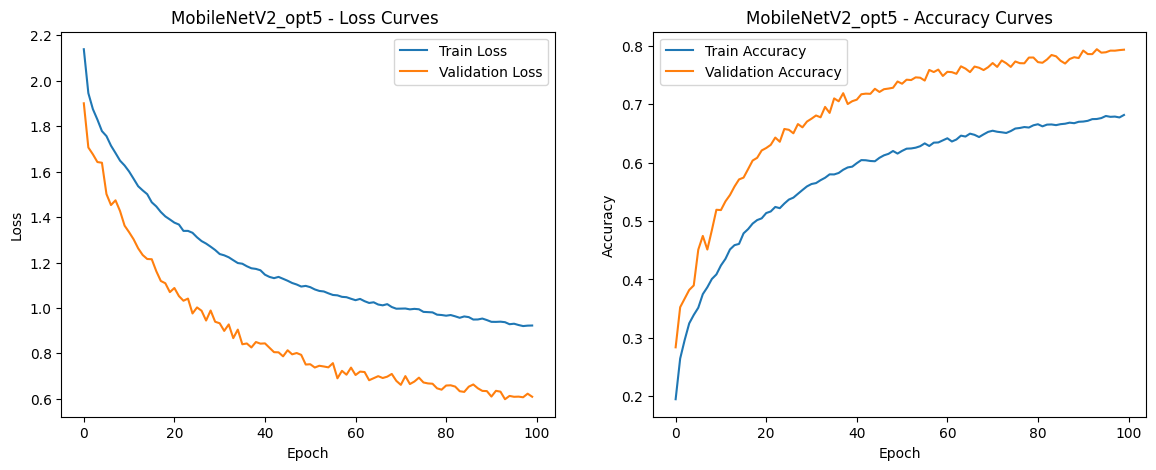

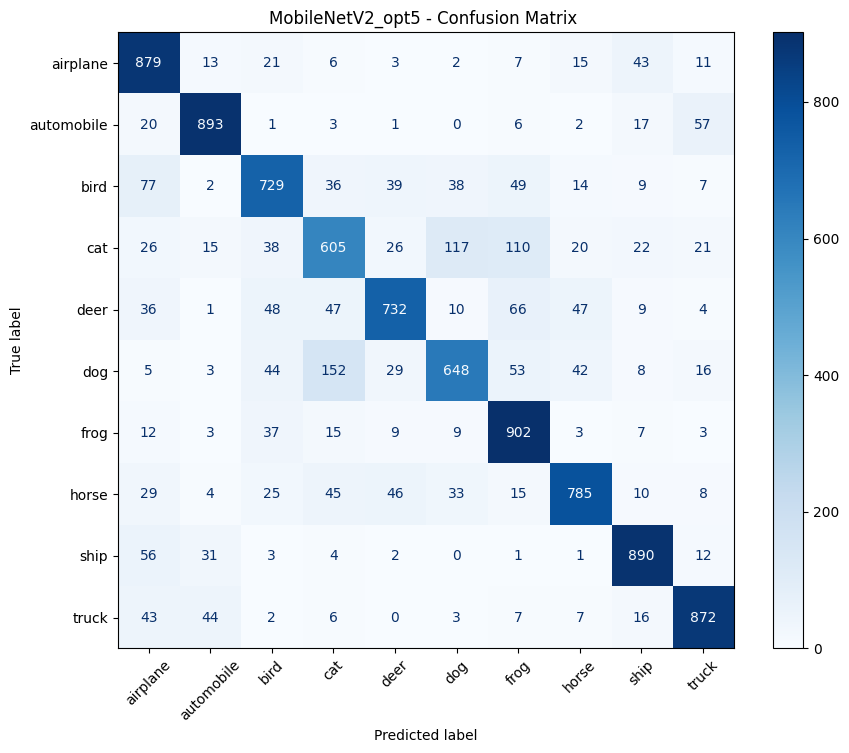

In [26]:
# Loss and accuracy curves 
model_name = "MobileNetV2_opt5"

model = models[f"mdl_{model_name}"] 
train_losses = models[f"train_loss_{model_name}"]
val_losses = models[f"val_loss_{model_name}"]
train_accuracies = models[f"train_acc_{model_name}"]
val_accuracies = models[f"val_acc_{model_name}"]

plot_loss_accuracy_curves(train_losses, val_losses, train_accuracies, val_accuracies, model_name=model_name)

# Plot confusion matrix
val_preds, val_labels = evaluate_model(model, val_dataset)
plot_confusion_matrix(val_labels, val_preds, classes=unique_classes, figsize=(10, 8), model_name=model_name) 


### MobileNetV2 model optimisation-6

In [32]:
#Define MobileNetV2 architecture without residual connections

class ConvBNReLU(nn.Sequential):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, groups=1):
        padding = (kernel_size - 1) // 2
        super(ConvBNReLU, self).__init__(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, groups=groups, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU6(inplace=True)
        )

class InvertedNoResidual(nn.Module):
    def __init__(self, in_channels, out_channels, stride, expand_ratio):
        super(InvertedNoResidual, self).__init__()
        hidden_dim = in_channels * expand_ratio

        layers = []
        if expand_ratio != 1:
            # 1x1 expansion
            layers.append(ConvBNReLU(in_channels, hidden_dim, kernel_size=1))
        # 3x3 depthwise convolution
        layers.extend([
            ConvBNReLU(hidden_dim, hidden_dim, stride=stride, groups=hidden_dim),
            # 1x1 projection
            nn.Conv2d(hidden_dim, out_channels, 1, 1, 0, bias=False),
            nn.BatchNorm2d(out_channels),
        ])
        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        return self.conv(x)


class MobileNetV2_nores(nn.Module):
    def __init__(self, num_classes=1000, width_mult=1.0):
        super(MobileNetV2_nores, self).__init__()
        inverted_residual_setting = [
            # t, c, n, s
            [1, 16, 1, 1],
            [6, 24, 2, 2],
            [6, 32, 3, 2],
            [6, 64, 4, 2],
            [6, 96, 3, 1],
            [6, 160, 3, 2],
            [6, 320, 1, 1],
        ]

        input_channel = 32
        last_channel = 1280

        # First layer
        self.features = [ConvBNReLU(3, input_channel, stride=2)]
        
        # Building inverted residual blocks without residuals
        for t, c, n, s in inverted_residual_setting:
            output_channel = int(c * width_mult)
            for i in range(n):
                stride = s if i == 0 else 1
                self.features.append(InvertedNoResidual(input_channel, output_channel, stride, expand_ratio=t))
                input_channel = output_channel
        
        # Last layers
        self.features.append(ConvBNReLU(input_channel, last_channel, kernel_size=1))
        
        # Combine feature layers
        self.features = nn.Sequential(*self.features)
        
        # Classifier layer
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(last_channel, num_classes),
        )

        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = x.mean([2, 3])  # Global average pooling
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.zeros_(m.bias)



In [33]:
# DataLoaders, edit batch size
train_loader_aug = DataLoader(train_subset_aug, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)
val_loader_128 = DataLoader(val_subset, batch_size=128, shuffle=False, num_workers=4)

# Hyperparameter tuning
model = MobileNetV2_nores(num_classes=10)
train_dataset = train_loader_aug
val_dataset = val_loader_128
optimizer=optim.Adam
learning_rate=0.0001
epochs =100
patience=10
regularization="L2"
regularization_strength=0.00001
models = {}
model_name = "MobileNetV2_opt6"

#Training model
model_train, train_loss, val_loss, train_acc, val_acc = train_model(model, train_dataset, val_dataset, optimizer=optimizer, 
                                                                        lr=learning_rate, epoch_num=epochs, patience=patience, model_name=model_name,
                                                                        regularization_type=regularization, regularization_strength=regularization_strength)

#save to each model name
models[f"mdl_{model_name}"] = model_train
models[f"train_loss_{model_name}"] = train_loss
models[f"val_loss_{model_name}"] = val_loss
models[f"train_acc_{model_name}"] = train_acc
models[f"val_acc_{model_name}"] = val_acc

Epoch 1/100, Train Loss: 2.3131, Train Accuracy: 0.1143, Validation Loss: 2.2884, Validation Accuracy: 0.1229


Epoch 2/100, Train Loss: 2.2985, Train Accuracy: 0.1188, Validation Loss: 2.2737, Validation Accuracy: 0.1352


Epoch 3/100, Train Loss: 2.2848, Train Accuracy: 0.1273, Validation Loss: 2.2472, Validation Accuracy: 0.1447


Epoch 4/100, Train Loss: 2.2585, Train Accuracy: 0.1376, Validation Loss: 2.2236, Validation Accuracy: 0.1550


Epoch 5/100, Train Loss: 2.2284, Train Accuracy: 0.1514, Validation Loss: 2.1875, Validation Accuracy: 0.1641


Epoch 6/100, Train Loss: 2.2032, Train Accuracy: 0.1592, Validation Loss: 2.1581, Validation Accuracy: 0.1762


Epoch 7/100, Train Loss: 2.1708, Train Accuracy: 0.1692, Validation Loss: 2.1326, Validation Accuracy: 0.1849


Epoch 8/100, Train Loss: 2.1540, Train Accuracy: 0.1755, Validation Loss: 2.1027, Validation Accuracy: 0.1997


Epoch 9/100, Train Loss: 2.1257, Train Accuracy: 0.1830, Validation Loss: 2.0820, Validation Accuracy: 0.1990


Epoch 10/100, Train Loss: 2.1110, Train Accuracy: 0.1899, Validation Loss: 2.0607, Validation Accuracy: 0.2093


Epoch 11/100, Train Loss: 2.0934, Train Accuracy: 0.1907, Validation Loss: 2.0485, Validation Accuracy: 0.2108


Epoch 12/100, Train Loss: 2.0868, Train Accuracy: 0.1950, Validation Loss: 2.0424, Validation Accuracy: 0.2054


Epoch 13/100, Train Loss: 2.0748, Train Accuracy: 0.2001, Validation Loss: 2.0177, Validation Accuracy: 0.2176


Epoch 14/100, Train Loss: 2.0567, Train Accuracy: 0.2087, Validation Loss: 1.9941, Validation Accuracy: 0.2339


Epoch 15/100, Train Loss: 2.0453, Train Accuracy: 0.2090, Validation Loss: 1.9807, Validation Accuracy: 0.2397


Epoch 16/100, Train Loss: 2.0337, Train Accuracy: 0.2198, Validation Loss: 1.9647, Validation Accuracy: 0.2452


Epoch 17/100, Train Loss: 2.0222, Train Accuracy: 0.2234, Validation Loss: 1.9472, Validation Accuracy: 0.2583


Epoch 18/100, Train Loss: 2.0059, Train Accuracy: 0.2324, Validation Loss: 1.9316, Validation Accuracy: 0.2726


Epoch 19/100, Train Loss: 1.9950, Train Accuracy: 0.2363, Validation Loss: 1.9065, Validation Accuracy: 0.2653


Epoch 20/100, Train Loss: 1.9783, Train Accuracy: 0.2446, Validation Loss: 1.8749, Validation Accuracy: 0.2905


Epoch 21/100, Train Loss: 1.9619, Train Accuracy: 0.2549, Validation Loss: 1.8529, Validation Accuracy: 0.3018


Epoch 22/100, Train Loss: 1.9479, Train Accuracy: 0.2605, Validation Loss: 1.8235, Validation Accuracy: 0.3169


Epoch 23/100, Train Loss: 1.9350, Train Accuracy: 0.2676, Validation Loss: 1.8184, Validation Accuracy: 0.3132


Epoch 24/100, Train Loss: 1.9236, Train Accuracy: 0.2745, Validation Loss: 1.7939, Validation Accuracy: 0.3201


Epoch 25/100, Train Loss: 1.9061, Train Accuracy: 0.2799, Validation Loss: 1.7726, Validation Accuracy: 0.3400


Epoch 26/100, Train Loss: 1.9009, Train Accuracy: 0.2809, Validation Loss: 1.7536, Validation Accuracy: 0.3546


Epoch 27/100, Train Loss: 1.8854, Train Accuracy: 0.2930, Validation Loss: 1.7342, Validation Accuracy: 0.3585


Epoch 28/100, Train Loss: 1.8691, Train Accuracy: 0.3004, Validation Loss: 1.7079, Validation Accuracy: 0.3632


Epoch 29/100, Train Loss: 1.8603, Train Accuracy: 0.2983, Validation Loss: 1.6984, Validation Accuracy: 0.3641


Epoch 30/100, Train Loss: 1.8507, Train Accuracy: 0.3075, Validation Loss: 1.6986, Validation Accuracy: 0.3660


Epoch 31/100, Train Loss: 1.8342, Train Accuracy: 0.3145, Validation Loss: 1.6639, Validation Accuracy: 0.3758


Epoch 32/100, Train Loss: 1.8258, Train Accuracy: 0.3150, Validation Loss: 1.6421, Validation Accuracy: 0.3897


Epoch 33/100, Train Loss: 1.8137, Train Accuracy: 0.3247, Validation Loss: 1.6303, Validation Accuracy: 0.3976


Epoch 34/100, Train Loss: 1.8115, Train Accuracy: 0.3216, Validation Loss: 1.6397, Validation Accuracy: 0.3969


Epoch 35/100, Train Loss: 1.8038, Train Accuracy: 0.3297, Validation Loss: 1.6206, Validation Accuracy: 0.3973


Epoch 36/100, Train Loss: 1.7893, Train Accuracy: 0.3313, Validation Loss: 1.6000, Validation Accuracy: 0.4012


Epoch 37/100, Train Loss: 1.7819, Train Accuracy: 0.3394, Validation Loss: 1.5777, Validation Accuracy: 0.4147


Epoch 38/100, Train Loss: 1.7697, Train Accuracy: 0.3454, Validation Loss: 1.5608, Validation Accuracy: 0.4237


Epoch 39/100, Train Loss: 1.7628, Train Accuracy: 0.3464, Validation Loss: 1.5689, Validation Accuracy: 0.4242


Epoch 40/100, Train Loss: 1.7523, Train Accuracy: 0.3498, Validation Loss: 1.5439, Validation Accuracy: 0.4296


Epoch 41/100, Train Loss: 1.7474, Train Accuracy: 0.3555, Validation Loss: 1.5325, Validation Accuracy: 0.4342


Epoch 42/100, Train Loss: 1.7463, Train Accuracy: 0.3559, Validation Loss: 1.5352, Validation Accuracy: 0.4397


Epoch 43/100, Train Loss: 1.7316, Train Accuracy: 0.3623, Validation Loss: 1.5232, Validation Accuracy: 0.4471


Epoch 44/100, Train Loss: 1.7253, Train Accuracy: 0.3638, Validation Loss: 1.5017, Validation Accuracy: 0.4534


Epoch 45/100, Train Loss: 1.7240, Train Accuracy: 0.3696, Validation Loss: 1.4866, Validation Accuracy: 0.4578


Epoch 46/100, Train Loss: 1.7134, Train Accuracy: 0.3698, Validation Loss: 1.4999, Validation Accuracy: 0.4477


Epoch 47/100, Train Loss: 1.7087, Train Accuracy: 0.3750, Validation Loss: 1.4732, Validation Accuracy: 0.4651


Epoch 48/100, Train Loss: 1.6987, Train Accuracy: 0.3750, Validation Loss: 1.4779, Validation Accuracy: 0.4622


Epoch 49/100, Train Loss: 1.6931, Train Accuracy: 0.3779, Validation Loss: 1.4640, Validation Accuracy: 0.4640


Epoch 50/100, Train Loss: 1.6853, Train Accuracy: 0.3823, Validation Loss: 1.4489, Validation Accuracy: 0.4784


Epoch 51/100, Train Loss: 1.6825, Train Accuracy: 0.3834, Validation Loss: 1.4446, Validation Accuracy: 0.4797


Epoch 52/100, Train Loss: 1.6756, Train Accuracy: 0.3871, Validation Loss: 1.4344, Validation Accuracy: 0.4805


Epoch 53/100, Train Loss: 1.6737, Train Accuracy: 0.3874, Validation Loss: 1.4358, Validation Accuracy: 0.4855


Epoch 54/100, Train Loss: 1.6627, Train Accuracy: 0.3912, Validation Loss: 1.4264, Validation Accuracy: 0.4847


Epoch 55/100, Train Loss: 1.6567, Train Accuracy: 0.3897, Validation Loss: 1.4128, Validation Accuracy: 0.4891


Epoch 56/100, Train Loss: 1.6539, Train Accuracy: 0.3961, Validation Loss: 1.4085, Validation Accuracy: 0.4909


Epoch 57/100, Train Loss: 1.6440, Train Accuracy: 0.4005, Validation Loss: 1.4133, Validation Accuracy: 0.4858


Epoch 58/100, Train Loss: 1.6397, Train Accuracy: 0.4037, Validation Loss: 1.3817, Validation Accuracy: 0.5023


Epoch 59/100, Train Loss: 1.6336, Train Accuracy: 0.4071, Validation Loss: 1.3972, Validation Accuracy: 0.4961


Epoch 60/100, Train Loss: 1.6245, Train Accuracy: 0.4093, Validation Loss: 1.3921, Validation Accuracy: 0.5012


Epoch 61/100, Train Loss: 1.6219, Train Accuracy: 0.4112, Validation Loss: 1.3833, Validation Accuracy: 0.4948


Epoch 62/100, Train Loss: 1.6148, Train Accuracy: 0.4167, Validation Loss: 1.3781, Validation Accuracy: 0.5032


Epoch 63/100, Train Loss: 1.6021, Train Accuracy: 0.4192, Validation Loss: 1.3663, Validation Accuracy: 0.5118


Epoch 64/100, Train Loss: 1.6035, Train Accuracy: 0.4160, Validation Loss: 1.3651, Validation Accuracy: 0.5075


Epoch 65/100, Train Loss: 1.6081, Train Accuracy: 0.4179, Validation Loss: 1.3519, Validation Accuracy: 0.5132


Epoch 66/100, Train Loss: 1.5907, Train Accuracy: 0.4234, Validation Loss: 1.3591, Validation Accuracy: 0.5111


Epoch 67/100, Train Loss: 1.5917, Train Accuracy: 0.4253, Validation Loss: 1.3385, Validation Accuracy: 0.5201


Epoch 68/100, Train Loss: 1.5894, Train Accuracy: 0.4249, Validation Loss: 1.3269, Validation Accuracy: 0.5221


Epoch 69/100, Train Loss: 1.5795, Train Accuracy: 0.4240, Validation Loss: 1.3314, Validation Accuracy: 0.5251


Epoch 70/100, Train Loss: 1.5752, Train Accuracy: 0.4300, Validation Loss: 1.3273, Validation Accuracy: 0.5205


Epoch 71/100, Train Loss: 1.5713, Train Accuracy: 0.4328, Validation Loss: 1.3191, Validation Accuracy: 0.5276


Epoch 72/100, Train Loss: 1.5722, Train Accuracy: 0.4319, Validation Loss: 1.2999, Validation Accuracy: 0.5319


Epoch 73/100, Train Loss: 1.5640, Train Accuracy: 0.4316, Validation Loss: 1.2982, Validation Accuracy: 0.5311


Epoch 74/100, Train Loss: 1.5572, Train Accuracy: 0.4369, Validation Loss: 1.2909, Validation Accuracy: 0.5350


Epoch 75/100, Train Loss: 1.5451, Train Accuracy: 0.4444, Validation Loss: 1.2826, Validation Accuracy: 0.5413


Epoch 76/100, Train Loss: 1.5463, Train Accuracy: 0.4413, Validation Loss: 1.2835, Validation Accuracy: 0.5373


Epoch 77/100, Train Loss: 1.5400, Train Accuracy: 0.4446, Validation Loss: 1.2784, Validation Accuracy: 0.5420


Epoch 78/100, Train Loss: 1.5393, Train Accuracy: 0.4451, Validation Loss: 1.2784, Validation Accuracy: 0.5396


Epoch 79/100, Train Loss: 1.5329, Train Accuracy: 0.4477, Validation Loss: 1.2645, Validation Accuracy: 0.5458


Epoch 80/100, Train Loss: 1.5217, Train Accuracy: 0.4487, Validation Loss: 1.2544, Validation Accuracy: 0.5492


Epoch 81/100, Train Loss: 1.5170, Train Accuracy: 0.4520, Validation Loss: 1.2446, Validation Accuracy: 0.5531


Epoch 82/100, Train Loss: 1.5155, Train Accuracy: 0.4544, Validation Loss: 1.2634, Validation Accuracy: 0.5443


Epoch 83/100, Train Loss: 1.5176, Train Accuracy: 0.4526, Validation Loss: 1.2425, Validation Accuracy: 0.5560


Epoch 84/100, Train Loss: 1.5109, Train Accuracy: 0.4552, Validation Loss: 1.2428, Validation Accuracy: 0.5547


Epoch 85/100, Train Loss: 1.5110, Train Accuracy: 0.4576, Validation Loss: 1.2304, Validation Accuracy: 0.5613


Epoch 86/100, Train Loss: 1.5066, Train Accuracy: 0.4566, Validation Loss: 1.2312, Validation Accuracy: 0.5573


Epoch 87/100, Train Loss: 1.4991, Train Accuracy: 0.4618, Validation Loss: 1.2209, Validation Accuracy: 0.5635


Epoch 88/100, Train Loss: 1.4916, Train Accuracy: 0.4671, Validation Loss: 1.2222, Validation Accuracy: 0.5670


Epoch 89/100, Train Loss: 1.4852, Train Accuracy: 0.4696, Validation Loss: 1.2095, Validation Accuracy: 0.5646


Epoch 90/100, Train Loss: 1.4851, Train Accuracy: 0.4668, Validation Loss: 1.2053, Validation Accuracy: 0.5683


Epoch 91/100, Train Loss: 1.4899, Train Accuracy: 0.4666, Validation Loss: 1.2001, Validation Accuracy: 0.5746


Epoch 92/100, Train Loss: 1.4818, Train Accuracy: 0.4674, Validation Loss: 1.2025, Validation Accuracy: 0.5701


Epoch 93/100, Train Loss: 1.4829, Train Accuracy: 0.4672, Validation Loss: 1.2054, Validation Accuracy: 0.5713


Epoch 94/100, Train Loss: 1.4708, Train Accuracy: 0.4703, Validation Loss: 1.1953, Validation Accuracy: 0.5784


Epoch 95/100, Train Loss: 1.4715, Train Accuracy: 0.4722, Validation Loss: 1.1916, Validation Accuracy: 0.5765


Epoch 96/100, Train Loss: 1.4630, Train Accuracy: 0.4773, Validation Loss: 1.1997, Validation Accuracy: 0.5719


Epoch 97/100, Train Loss: 1.4663, Train Accuracy: 0.4738, Validation Loss: 1.1926, Validation Accuracy: 0.5709


Epoch 98/100, Train Loss: 1.4576, Train Accuracy: 0.4772, Validation Loss: 1.1876, Validation Accuracy: 0.5681


Epoch 99/100, Train Loss: 1.4502, Train Accuracy: 0.4819, Validation Loss: 1.1775, Validation Accuracy: 0.5788


Epoch 100/100, Train Loss: 1.4487, Train Accuracy: 0.4824, Validation Loss: 1.1572, Validation Accuracy: 0.5824
Training complete. Final model saved at 'models/MobileNetV2_opt6.pth'


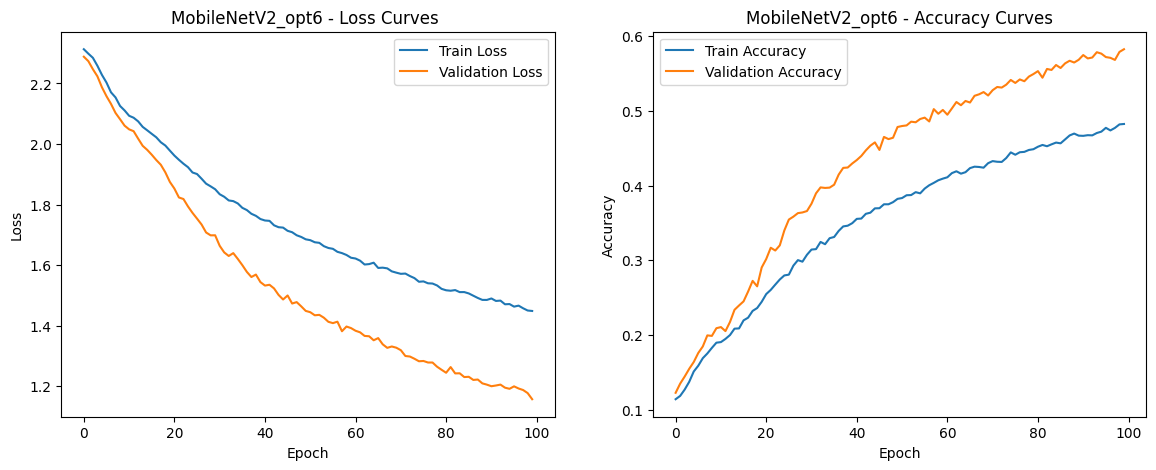

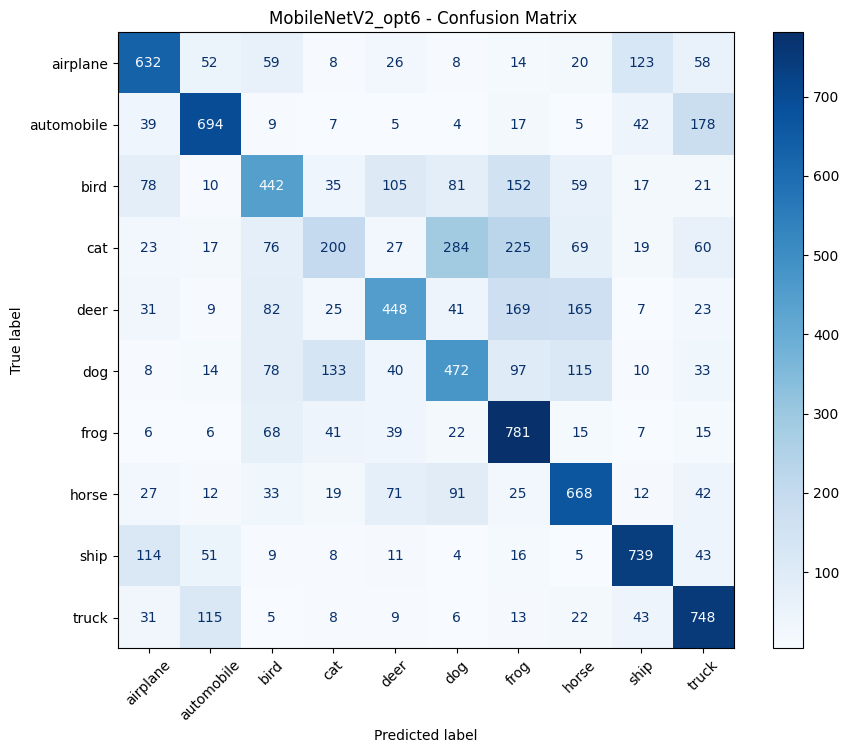

In [34]:
# Loss and accuracy curves 
model_name = "MobileNetV2_opt6"

model = models[f"mdl_{model_name}"] 
train_losses = models[f"train_loss_{model_name}"]
val_losses = models[f"val_loss_{model_name}"]
train_accuracies = models[f"train_acc_{model_name}"]
val_accuracies = models[f"val_acc_{model_name}"]

plot_loss_accuracy_curves(train_losses, val_losses, train_accuracies, val_accuracies, model_name=model_name)

# Plot confusion matrix
val_preds, val_labels = evaluate_model(model, val_dataset)
plot_confusion_matrix(val_labels, val_preds, classes=unique_classes, figsize=(10, 8), model_name=model_name) 


### MobileNetV2 model optimisation-7

In [ ]:
# DataLoaders, edit batch size
train_loader_aug = DataLoader(train_subset_aug, batch_size=512, shuffle=True, num_workers=4, pin_memory=True)
val_loader_512 = DataLoader(val_subset, batch_size=512, shuffle=False, num_workers=4)

# Hyperparameter tuning
model = MobileNetV2(num_classes=10)
train_dataset = train_loader_aug
val_dataset = val_loader_512
optimizer=optim.NAdam
learning_rate=0.001
epochs =100
patience=10
regularization=None
regularization_strength=None
models = {}
model_name = "MobileNetV2_opt7"

#Training model
model_train, train_loss, val_loss, train_acc, val_acc = train_model(model, train_dataset, val_dataset, optimizer=optimizer, 
                                                                        lr=learning_rate, epoch_num=epochs, patience=patience, model_name=model_name,
                                                                        regularization_type=regularization, regularization_strength=regularization_strength)

#save to each model name
models[f"mdl_{model_name}"] = model_train
models[f"train_loss_{model_name}"] = train_loss
models[f"val_loss_{model_name}"] = val_loss
models[f"train_acc_{model_name}"] = train_acc
models[f"val_acc_{model_name}"] = val_acc

In [ ]:
# Loss and accuracy curves 
model_name = "MobileNetV2_opt7"

model = models[f"mdl_{model_name}"] 
train_losses = models[f"train_loss_{model_name}"]
val_losses = models[f"val_loss_{model_name}"]
train_accuracies = models[f"train_acc_{model_name}"]
val_accuracies = models[f"val_acc_{model_name}"]

plot_loss_accuracy_curves(train_losses, val_losses, train_accuracies, val_accuracies, model_name=model_name)

# Plot confusion matrix
val_preds, val_labels = evaluate_model(model, val_dataset)
plot_confusion_matrix(val_labels, val_preds, classes=unique_classes, figsize=(10, 8), model_name=model_name) 


MobileNetV2_base Accuracy: 0.6131
MobileNetV2_opt1 Accuracy: 0.3191
MobileNetV2_opt2 Accuracy: 0.3188
MobileNetV2_opt3 Accuracy: 0.3271
MobileNetV2_opt4 Accuracy: 0.3982
MobileNetV2_opt5 Accuracy: 0.7935
MobileNetV2_opt6 Accuracy: 0.5824


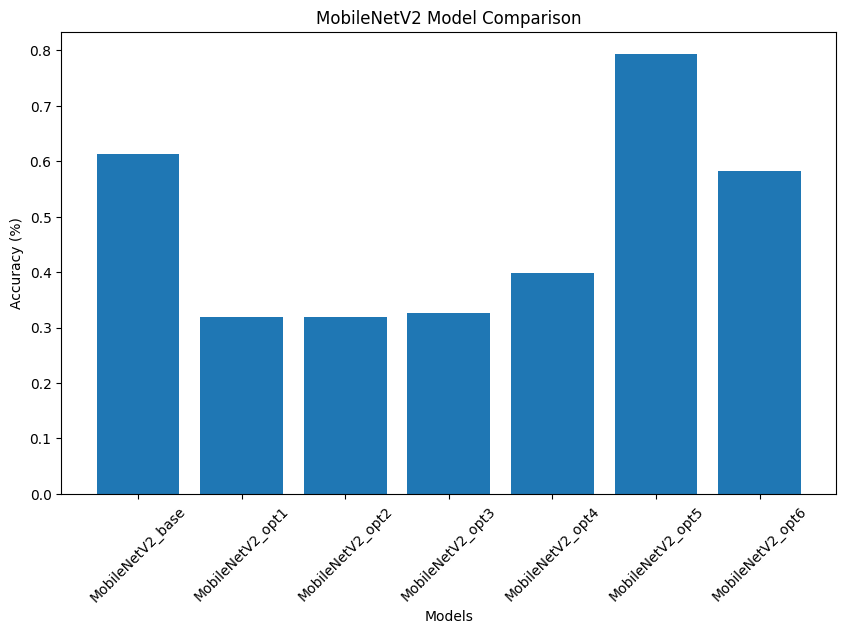

In [38]:
#Define the accuracy values

MobileNetV2_base_val_acc = 0.6131
MobileNetV2_opt1_val_acc = 0.3191
MobileNetV2_opt2_val_acc = 0.3188
MobileNetV2_opt3_val_acc = 0.3271
MobileNetV2_opt4_val_acc = 0.3982
MobileNetV2_opt5_val_acc = 0.7935
MobileNetV2_opt6_val_acc = 0.5824


model_accuracies = {
    "MobileNetV2_base": MobileNetV2_base_val_acc,
    "MobileNetV2_opt1": MobileNetV2_opt1_val_acc,
    "MobileNetV2_opt2": MobileNetV2_opt2_val_acc,
    "MobileNetV2_opt3": MobileNetV2_opt3_val_acc,
    "MobileNetV2_opt4": MobileNetV2_opt4_val_acc,
    "MobileNetV2_opt5": MobileNetV2_opt5_val_acc,
    "MobileNetV2_opt6": MobileNetV2_opt6_val_acc,
}

# Print each model's accuracy
for model_name, accuracy in model_accuracies.items():
    print(f"{model_name} Accuracy: {accuracy:.4f}")

# Plotting the accuracies using a bar chart
plt.figure(figsize=(10, 6))
plt.bar(model_accuracies.keys(), model_accuracies.values())
plt.xlabel("Models")
plt.ylabel("Accuracy (%)")
plt.xticks(rotation=45)
plt.title("MobileNetV2 Model Comparison")
plt.show()


D:\Users\a1913327\AppData\Local\Temp\2\ipykernel_12240\209814675.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('models/MobileNetV2_op

Test Loss: 0.6166
Test Accuracy: 79.1200%


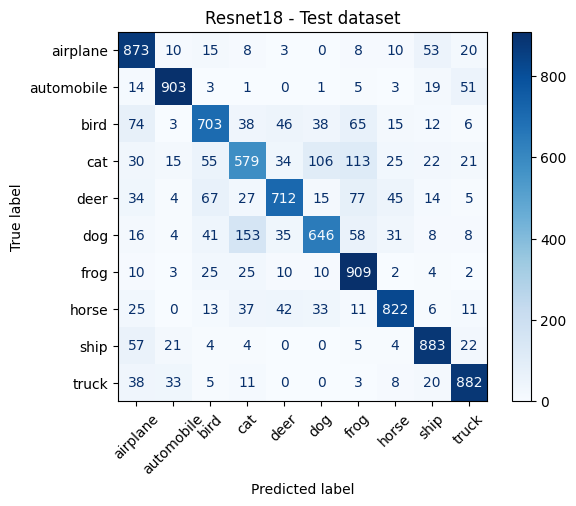

In [41]:
# Set the device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Re-instantiate your model architecture
# Replace `YourModelClass` with the actual class name of your model
model = MobileNetV2()
model.to(device)

# Load the model state_dict
model.load_state_dict(torch.load('models/MobileNetV2_opt5.pth'))
model.eval()

# Define the DataLoader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=2)

# Initialize variables to store metrics
test_loss = 0
correct = 0
total = 0
all_labels = []
all_predictions = []

# Disable gradient computation for evaluation
with torch.no_grad():
    for images, labels in test_loader:
        # Move images and labels to the GPU
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        
        # Calculate loss
        loss = F.cross_entropy(outputs, labels)
        test_loss += loss.item() * labels.size(0)  # Accumulate loss
        
        # Get predicted classes
        _, predicted = torch.max(outputs, 1)
        
        # Update total and correct predictions
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Store predictions and labels for confusion matrix
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Calculate average loss and accuracy
average_loss = test_loss / total
accuracy = 100 * correct / total

print(f'Test Loss: {average_loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}%')

# Confusion Matrix
cm = confusion_matrix(all_labels, all_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_dataset.classes)
disp.plot(cmap='Blues')
plt.plot(figsize=(8,8))
plt.xticks(rotation=45)
plt.title('Resnet18 - Test dataset')
plt.show()

